# Human Diversity Data

This notebook includes getting the human diversity data in shape for the model fitting. 

## Configuration

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import copy
from functools import partial
import numpy as np
import scipy.stats as stats
from scipy import interpolate
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from bgspy.genome import Genome
from bgspy.utils import mean_ratio, rel_error
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.data import pi_from_pairwise_summaries

In [6]:
plt.show()

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Data Loading

In [8]:
autosomes = [f'chr{x}' for x in range(1, 23)]
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=autosomes)
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chrX


### Masking notes

I use the following masks:

 - **Non-"putatively" neutral masks**: masked out phastcons + genic regions, but added introns in.
 - **Accessible masks**: no centromere + some buffer around centromeres.
 - **Reference genome softmasks**: ignore softmasked regions, e.g. due to repeats.
 
More information is in the supplementary materials.

In [9]:
gd = GenomeData(g)
gd.load_counts_dir('../data/h1kg/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')
gd.load_fasta('../data/annotation/hg38.fa.gz')

What gets masked out?

In [10]:
# tuple values are: fraction accessible, neutral, both
gd.mask_stats()

{'chr1': (0.424, 0.644, 0.229),
 'chr2': (0.468, 0.587, 0.237),
 'chr3': (0.441, 0.629, 0.248),
 'chr4': (0.44, 0.593, 0.215),
 'chr5': (0.441, 0.58, 0.214),
 'chr6': (0.45, 0.58, 0.221),
 'chr7': (0.444, 0.658, 0.264),
 'chr8': (0.438, 0.612, 0.231),
 'chr9': (0.392, 0.645, 0.203),
 'chr10': (0.446, 0.628, 0.253),
 'chr11': (0.427, 0.635, 0.234),
 'chr12': (0.417, 0.627, 0.227),
 'chr13': (0.397, 0.62, 0.183),
 'chr14': (0.376, 0.654, 0.19),
 'chr15': (0.37, 0.694, 0.203),
 'chr16': (0.394, 0.638, 0.209),
 'chr17': (0.404, 0.64, 0.223),
 'chr18': (0.409, 0.598, 0.198),
 'chr19': (0.309, 0.698, 0.18),
 'chr20': (0.369, 0.616, 0.198),
 'chr21': (0.316, 0.686, 0.182),
 'chr22': (0.269, 0.75, 0.164)}

This seems high but most of the genome is masked out repeats, ~47.5% (according to the [RepeatMasker](https://www.repeatmasker.org/species/hg.html) website), which we do not include due to the difficult of accurate alignment and variant calling in this region.

Let's output this as a supplementary table (perhaps just in GH repo):

In [11]:
mstats_tab = [{'chrom': c, 'accessible': 100*a, 'neutral': 100*n, 'both': 100*b, 
              #'basepairs':  int(g.seqlens[c]*b)
              } for
              c, (a, n, b) in gd.mask_stats().items()]
mstats_df = pd.DataFrame(mstats_tab)
mstats_df.to_csv('../data/supplementary_data/accessibilty.tsv', sep='\t', index=False)
mstats_df.head()

,chrom,accessible,neutral,both
0,chr1,42.4,64.4,22.9
1,chr2,46.8,58.7,23.7
2,chr3,44.1,62.9,24.8
3,chr4,44.0,59.3,21.5
4,chr5,44.1,58.0,21.4


In [12]:
# uncomment and run for supplementary table
# print(mstats_df.to_latex(index=False))

## Genome-wide Diversity

This is mostly validation of my functions to calculate $\pi$.


### My Sample
 
My sample came from a different project that didn't work out — it was originally CEU, CHB, and YRI samples from the dataset; 460 total. The underlying data is the 1000 Genomes [30x on GRCh38 dataset](https://www.internationalgenome.org/data-portal/data-collection/30x-grch38), of which there are 178 total YRI individuals.

The samples are in `../data/h1kg/yri_samples.tsv`.

Let's validate for chr1 counts of alleles that we have less than diploid individuals:

In [13]:
# not checked in to GH due to size
counts_chr1 = np.load('../data/h1kg/hg1k_counts/chr1_counts.npy')
counts_chr1.sum(axis=1).max() / 2

178.0

Looks good — my raw data is the complete YRI sample.

### Validation of Diversity

First, let's evaluate and do some validation for my methods for calculating genome-wide diversity in this sample.

The likelihood methods use binned allele counts, summed across all sites in the bin. These should be invariant to the bin width. So I check this below, looking at binned diversity at the megabase and 100kbp scales. Bins with high levels of inaccessible bases (`mask_inaccessible_bins_frac`) are *not* masked here, just for validation.

In [98]:
bins_1Mbp = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=True, 
                                      filter_accessible=True,
                                      mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [15]:
bins_100kbp = gd.bin_pairwise_summaries(width=1e5, 
                                        filter_neutral=True, 
                                        filter_accessible=True,
                                        mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [16]:
# verify that no windows are masked (we set mask_inaccessible_bins_frac = None and not
# outlier based filtering has been applied)
assert(bins_1Mbp.Y(filter_masked=True).mean() == bins_1Mbp.Y(filter_masked=False).mean())

In [17]:
# calculate the Y matrices, which are binned sums of allele counts
Y_1Mbp = bins_1Mbp.Y()
Y_100kbp = bins_100kbp.Y()

In [18]:
# naive unweighted sum -- this does not weight diversity
# in windows by their size of accessible bases 
np.nanmean(pi_from_pairwise_summaries(Y_1Mbp)), np.nanmean(pi_from_pairwise_summaries(Y_100kbp)), 

(0.001061762888014659, 0.0011025111972951217)

These don't match — but that is expected, since the unweighted mean is taken.

If instead we sum all columns, then calculate pairwise diversity, no information is lost:

In [19]:
pi_from_pairwise_summaries(Y_1Mbp.sum(axis=0)[None, :]), pi_from_pairwise_summaries(Y_100kbp.sum(axis=0)[None, :])

(array([0.00106413]), array([0.00106413]))

Which gives us identical values as expected.

Now, let's look at the genome-wide average in accessible putatively neutral regions.

In [32]:
gw_yri = gd.gwpi(filter_neutral=True, filter_accessible=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [33]:
gw_yri

0.0010642288382795434

In [53]:
# what's the relative error between binned averages and genome-wide?

rel_error(gw_yri, pi_from_pairwise_summaries(Y_1Mbp.sum(axis=0)[None, :]))

array([0.00918248])

Note, there is some small relative error between binning and the full genome-approach based on weighting chromosomes. This is from unknown numeric issues, but is such a small scale that we can ignore it.

Now, let's look at diversity across each chromosome separately.

In [36]:
pi_chroms = gd.pi(filter_neutral=True, filter_accessible=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [61]:
# pi_chrom genome-wide
pi_ests = np.array(list(pi_chroms[0].values())).flat
np.average(pi_ests, weights=list(pi_chroms[1].values()))

0.0010642288382795434

This agrees with the `gd.pi()` estimates (as it should, since it's doing the same weighted average internally). But note that this differs slightly from the binned average as mentioned above.

## Sensitivity to Various Filters

Compare that to the value without filtering based on accessibility only, not putatively neutral.

In [62]:
gw_yri_accessible_only = gd.gwpi(filter_neutral=False, filter_accessible=True)
gw_yri_accessible_only

  0%|          | 0/22 [00:00<?, ?it/s]

0.0010695775532157217

What if we don't filter at all? The estimate is much higher:

In [63]:
gw_yri_unfiltered = gd.gwpi(filter_neutral=False, filter_accessible=False)
gw_yri_unfiltered

  0%|          | 0/22 [00:00<?, ?it/s]

0.0013231492307452114

In [64]:
bins_1Mbp_accessible_only = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=False, 
                                      filter_accessible=True,
                                      mask_inaccessible_bins_frac=None)
bins_1Mbp_unfiltered = gd.bin_pairwise_summaries(width=1e6, 
                                      filter_neutral=False, 
                                      filter_accessible=False,
                                      mask_inaccessible_bins_frac=None)

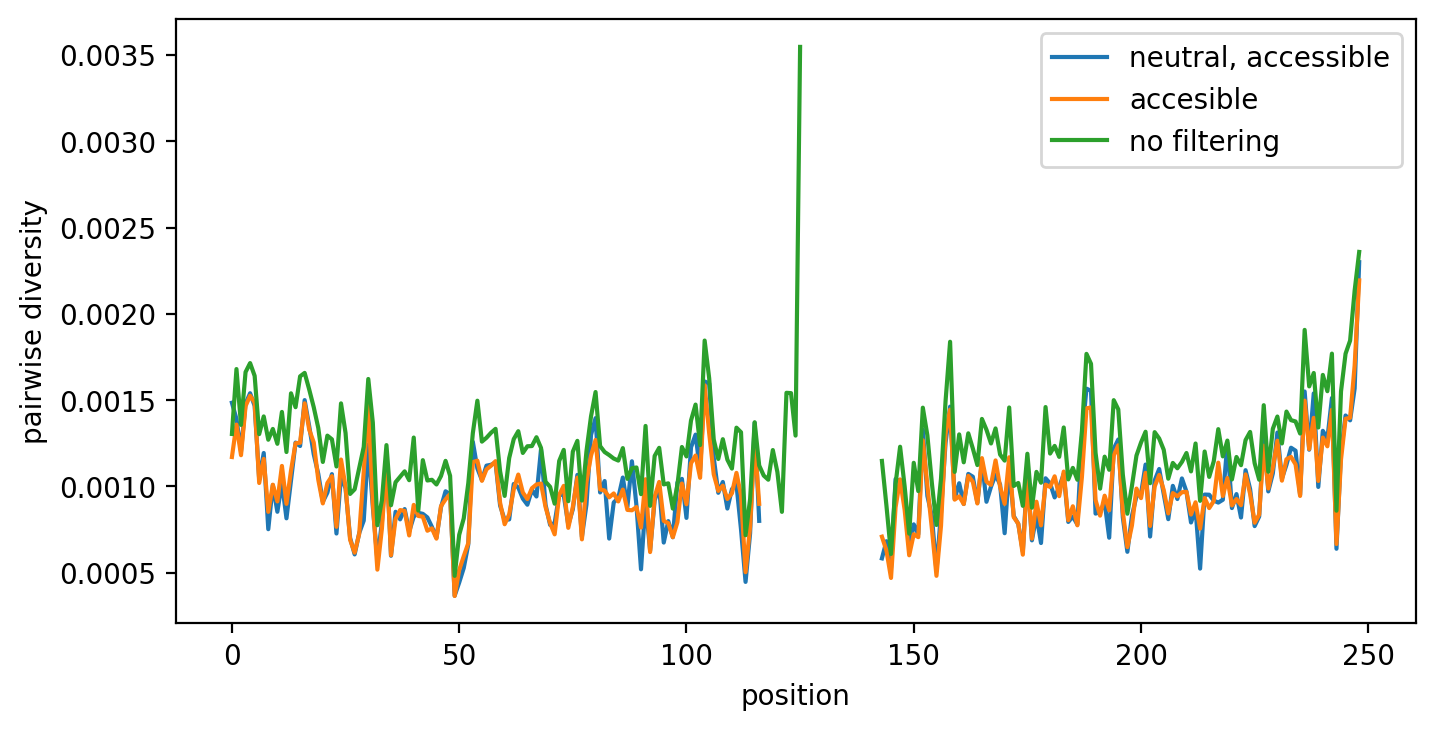

In [70]:
idx = bins_1Mbp.chrom_indices('chr1')

pi_chr1_filtered = pi_from_pairwise_summaries(bins_1Mbp.Y()[idx, :])
pi_chr1_accessible_only = pi_from_pairwise_summaries(bins_1Mbp_accessible_only.Y()[idx, :])
pi_chr1_no_filtering = pi_from_pairwise_summaries(bins_1Mbp_unfiltered.Y()[idx, :])
plt.plot(pi_chr1_filtered, label='neutral, accessible')
plt.plot(pi_chr1_accessible_only, label='accesible')
plt.plot(pi_chr1_no_filtering, label='no filtering')
plt.ylabel('pairwise diversity')
plt.xlabel('position')
plt.legend()

(0.0002, 0.002)

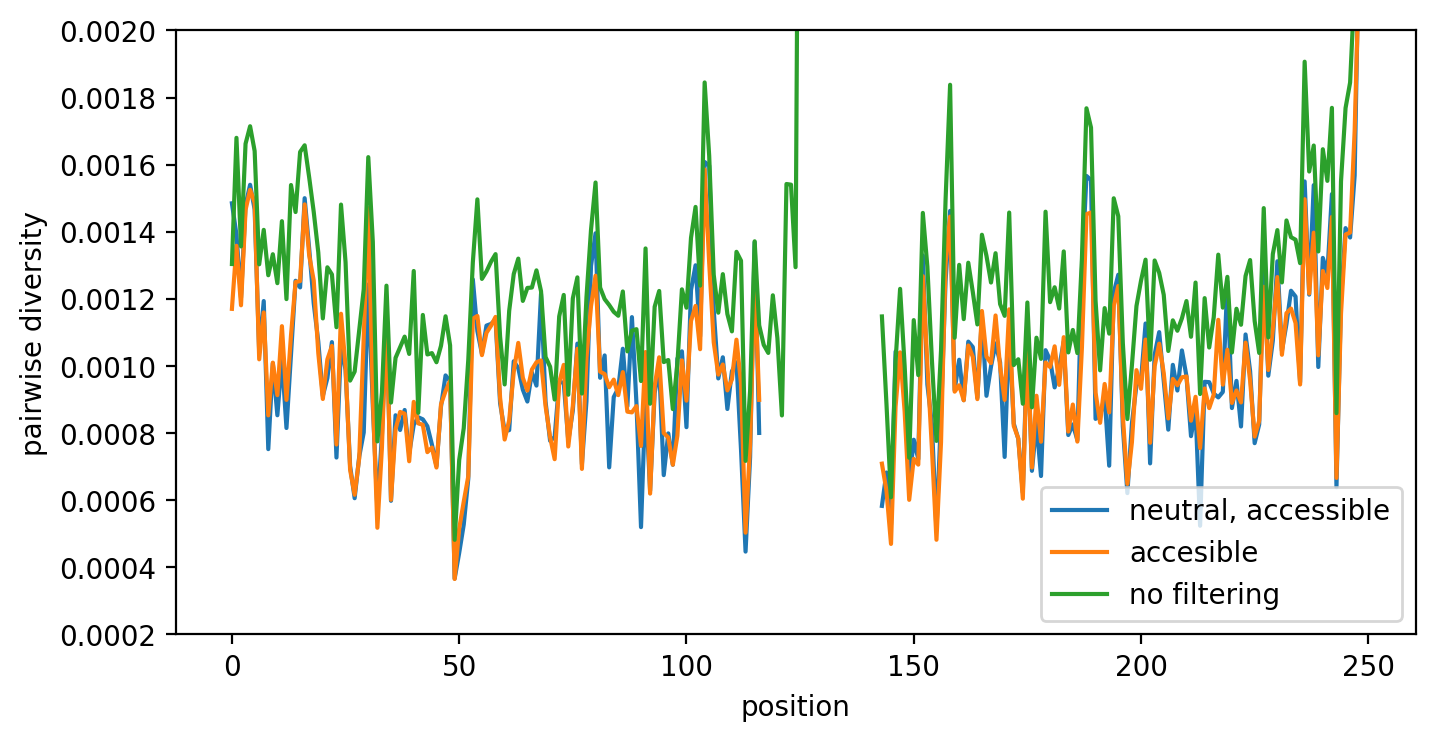

In [77]:
idx = bins_1Mbp.chrom_indices('chr1')

pi_chr1_filtered = pi_from_pairwise_summaries(bins_1Mbp.Y()[idx, :])
pi_chr1_accessible_only = pi_from_pairwise_summaries(bins_1Mbp_accessible_only.Y()[idx, :])
pi_chr1_no_filtering = pi_from_pairwise_summaries(bins_1Mbp_unfiltered.Y()[idx, :])
plt.plot(pi_chr1_filtered, label='neutral, accessible')
plt.plot(pi_chr1_accessible_only, label='accesible')
plt.plot(pi_chr1_no_filtering, label='no filtering')
plt.ylabel('pairwise diversity')
plt.xlabel('position')
plt.legend()
plt.ylim(0.0002, 0.002)

In [76]:
np.nanmean(pi_from_pairwise_summaries(Y[bins_1Mbp.chrom_indices('chr1'), :])), pi_chroms[0]['chr1']

(0.0009831068034906862, 0.001004543985241286)

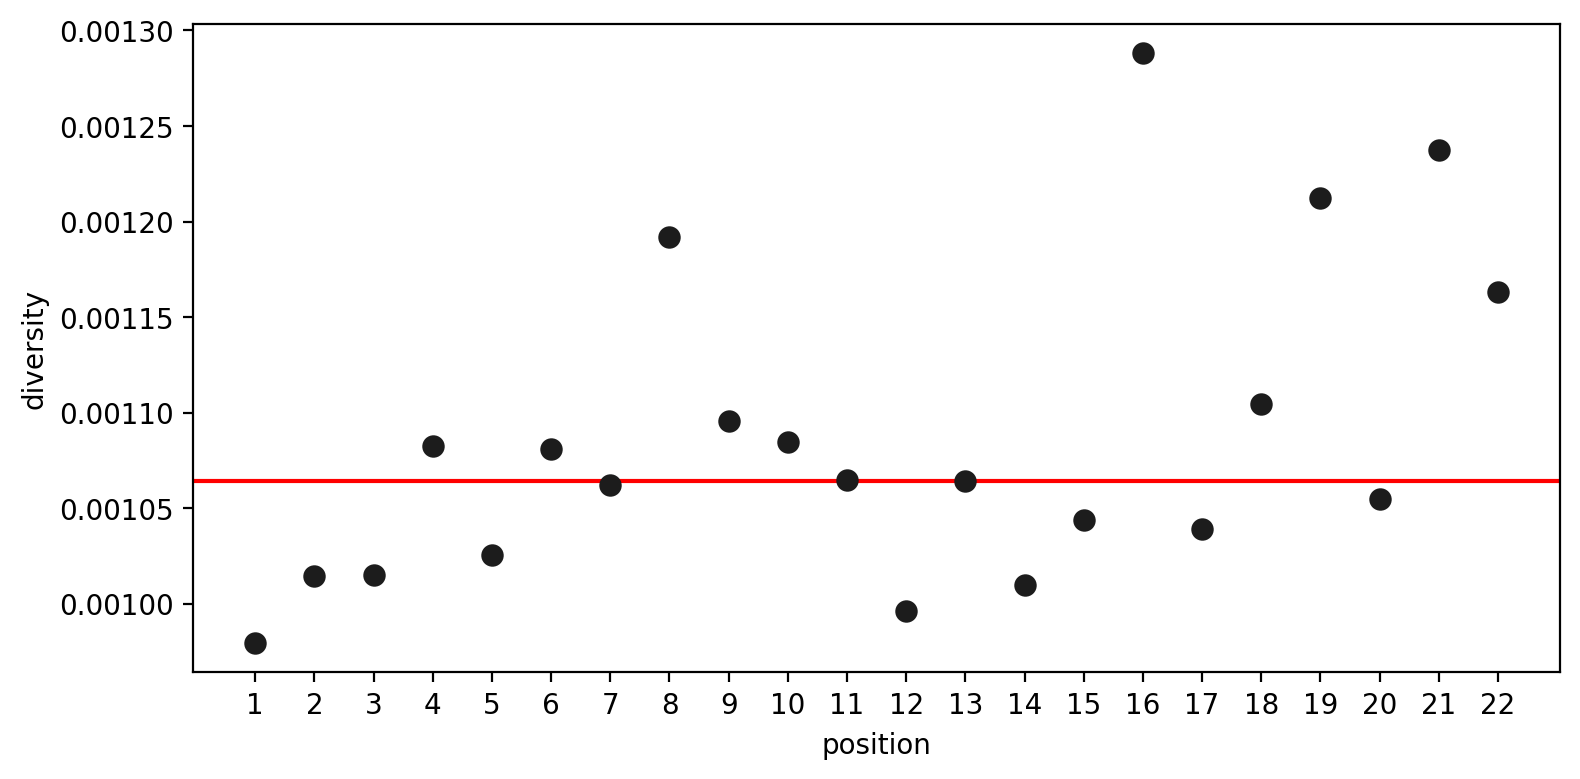

In [80]:
plt.scatter([x.replace('chr', '') for x in pi_chroms[0].keys()], pi_chroms[0].values(),
            c='0.11', s=50)
plt.axhline(gw_yri, c='r', zorder=-1)
plt.ylabel('diversity')
plt.xlabel('position')
plt.tight_layout()

In [127]:
# make a version for trimming specifically
bins_1Mbp_trimmed = gd.bin_pairwise_summaries(width=1e6, 
                                              filter_neutral=True, 
                                              filter_accessible=True,
                                              mask_inaccessible_bins_frac=None)

  0%|          | 0/22 [00:00<?, ?it/s]

In [144]:
bins_1Mbp_trimmed.clear_masks()
bins_1Mbp_trimmed.mask_outliers((0, 0.995))

In [132]:
np.unique(bins_1Mbp.chrom_ints())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

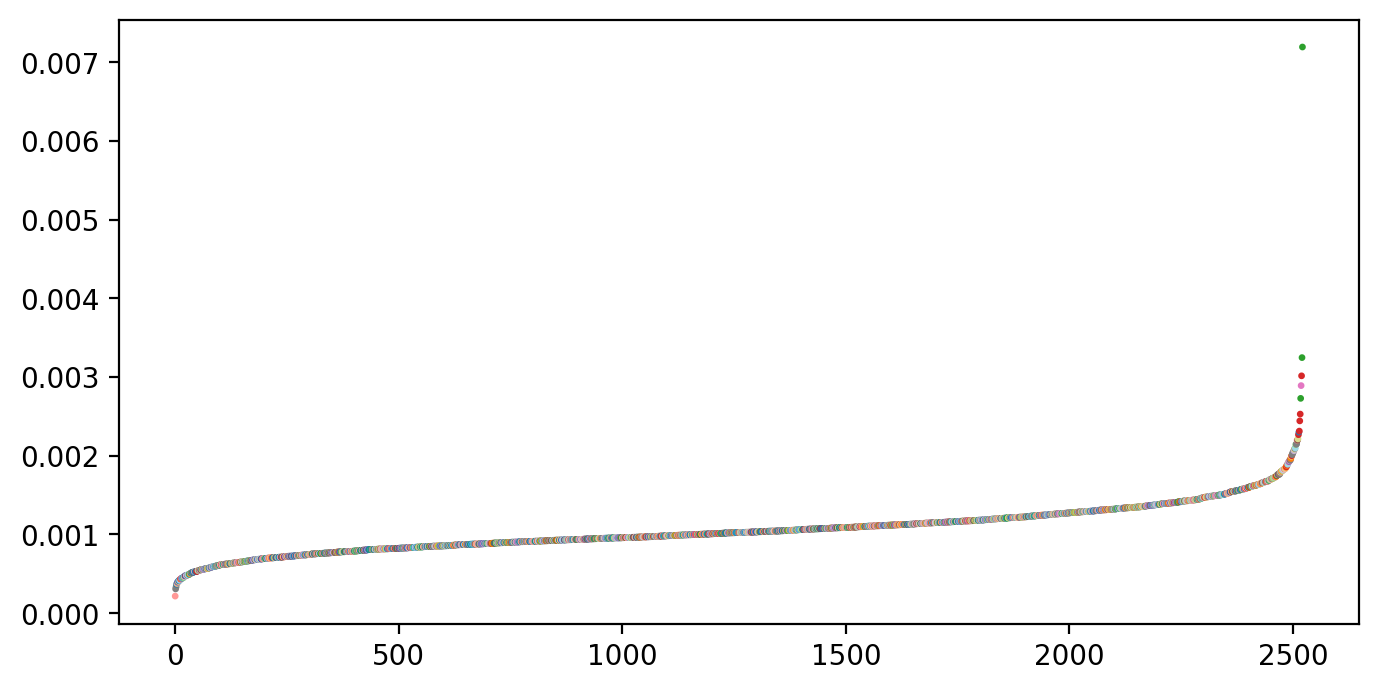

In [119]:
# quick check — do the chromosomes blend? yes.
fig, ax = plt.subplots()
pis = pi_from_pairwise_summaries(bins_1Mbp.Y())
idx = np.argsort(pis)
ax.scatter(np.arange(len(pis)), pis[idx], c=bins_1Mbp.chrom_ints()[idx], s=2, 
           cmap=mpl.colormaps.get_cmap('tab20'))

In [155]:
bins_1Mbp_trimmed.mask_array()

array([ True,  True,  True, ...,  True,  True,  True])

In [199]:
pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=True))
loc, scale = stats.norm.fit(pis_trimmed)

In [200]:
loc, scale

(0.001052640396427994, 0.0002823088256082406)

Text(0.5, 0, 'rank')

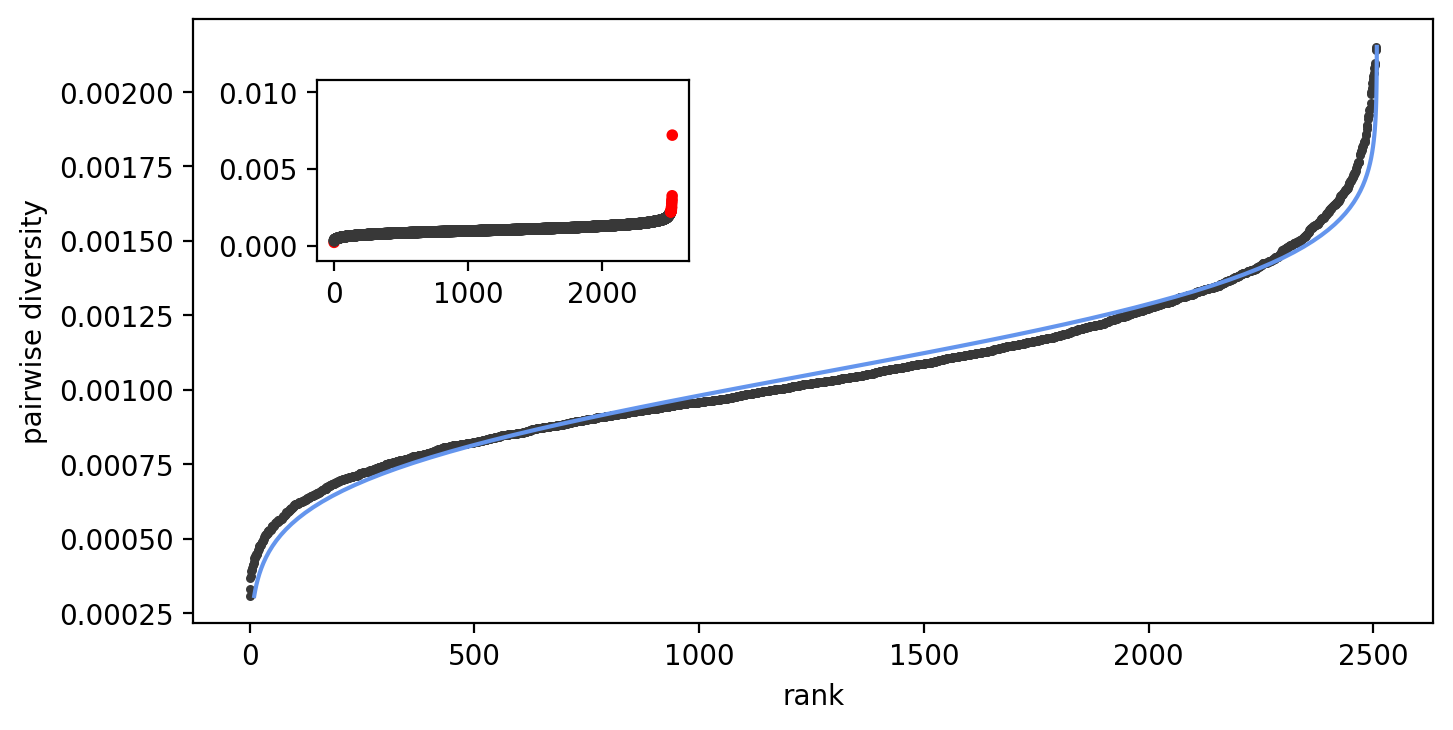

In [240]:
bins_1Mbp_trimmed.clear_masks()
bins_1Mbp_trimmed.mask_outliers((0, 0.995))

fig, ax = plt.subplots()
pis = pi_from_pairwise_summaries(bins_1Mbp.Y())
pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=False))

masked = bins_1Mbp_trimmed.mask_array()

#col = [{True: '0.22', False: 'c'}[p in pis_trimmed] for p in pis]
#ax.scatter(np.arange(len(pis)), np.sort(pis), s=2)

idx = np.argsort(pis_trimmed)

inset_ax = ax.inset_axes([0.1, 0.6, 0.3, 0.3])

inset_ax.scatter(np.arange(len(pis_trimmed)), pis_trimmed[idx], c=masked[idx], s=10,
           cmap=mpl.colors.LinearSegmentedColormap.from_list('outliers', ['red', '0.22']))

inset_ax.plot()
inset_ax.set_ylim(-0.001, np.nanmax(pis_trimmed[idx])*1.5)

pis_trimmed = pi_from_pairwise_summaries(bins_1Mbp_trimmed.Y(filter_masked=True))

z = np.linspace(np.nanmin(pis_trimmed), np.nanmax(pis_trimmed), 100)
ax.plot(stats.norm.cdf(z, loc, scale)*len(pis_trimmed), z, c='cornflowerblue')
ax.scatter(np.arange(len(pis_trimmed)), np.sort(pis_trimmed), s=5, c='0.22')

ax.set_ylabel('pairwise diversity')
ax.set_xlabel('rank')

In [204]:
z = np.linspace(pis_trimmed.min(), pis_trimmed.max(), 100)
stats.norm.cdf(z, loc, scale)

array([0.00413678, 0.00501623, 0.00605849, 0.00728832, 0.00873318,
       0.01042329, 0.01239169, 0.01467425, 0.01730961, 0.0203391 ,
       0.02380651, 0.02775792, 0.03224134, 0.03730628, 0.04300333,
       0.04938353, 0.05649778, 0.06439607, 0.07312672, 0.08273552,
       0.09326488, 0.10475286, 0.11723231, 0.1307299 , 0.1452653 ,
       0.1608503 , 0.17748813, 0.19517275, 0.21388837, 0.23360908,
       0.25429859, 0.27591021, 0.298387  , 0.32166203, 0.34565899,
       0.3702928 , 0.39547051, 0.42109237, 0.44705296, 0.4732425 ,
       0.49954826, 0.52585598, 0.5520514 , 0.57802168, 0.60365694,
       0.62885159, 0.65350564, 0.67752591, 0.70082704, 0.72333238,
       0.7449747 , 0.76569669, 0.78545131, 0.80420191, 0.82192223,
       0.83859614, 0.85421727, 0.86878854, 0.88232147, 0.89483545,
       0.90635695, 0.9169186 , 0.92655832, 0.93531836, 0.94324443,
       0.95038476, 0.95678932, 0.96250897, 0.96759476, 0.9720973 ,
       0.97606617, 0.97954942, 0.98259319, 0.98524138, 0.98753

### YRI Diversity Estimates with CIs

## Chromosome 1 Pairwise Diversity Compared to Other Studies.

Here we focus on megabase-scale variation, as this is the scale to see BGS effects (and it allows us to compare our diversity levels to those of Murphy et al. (2022)).

In [12]:
bins, pi = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)
bins_alt, pi_alt = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

This file is from Murillo Rodrigues forthcoming paper on diversity and divergence across the great apes — it uses data aligned to hg18. Note that I have *not* lifted this over to hg38, so some discrepencies are due to different genomic coordinates.

In [13]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo') & (dalt.spp2 == 'homo')]
dalt_dxy = dalt.loc[(dalt.stat == 'dxy') & (dalt.spp2 == 'homo') &  
                    ((dalt.spp1 == 'weastern_chimp') | (dalt.spp1 == 'eastern_chimp'))]

In [14]:
dalt_dxy.head()

,value,stat,spp1,spp2,chr,start,end,n_acc_bases,n_snps,midpoint
15624,NaN,dxy,eastern_chimp,homo,chr1,1,1000000,0,0,500000.5
15625,0.012834,dxy,eastern_chimp,homo,chr1,1000001,2000000,283857,7487,1500000.5
15626,0.014483,dxy,eastern_chimp,homo,chr1,2000001,3000000,455783,13809,2500000.5
15627,0.015186,dxy,eastern_chimp,homo,chr1,3000001,4000000,570312,17927,3500000.5
15628,0.015014,dxy,eastern_chimp,homo,chr1,4000001,5000000,794579,24642,4500000.5


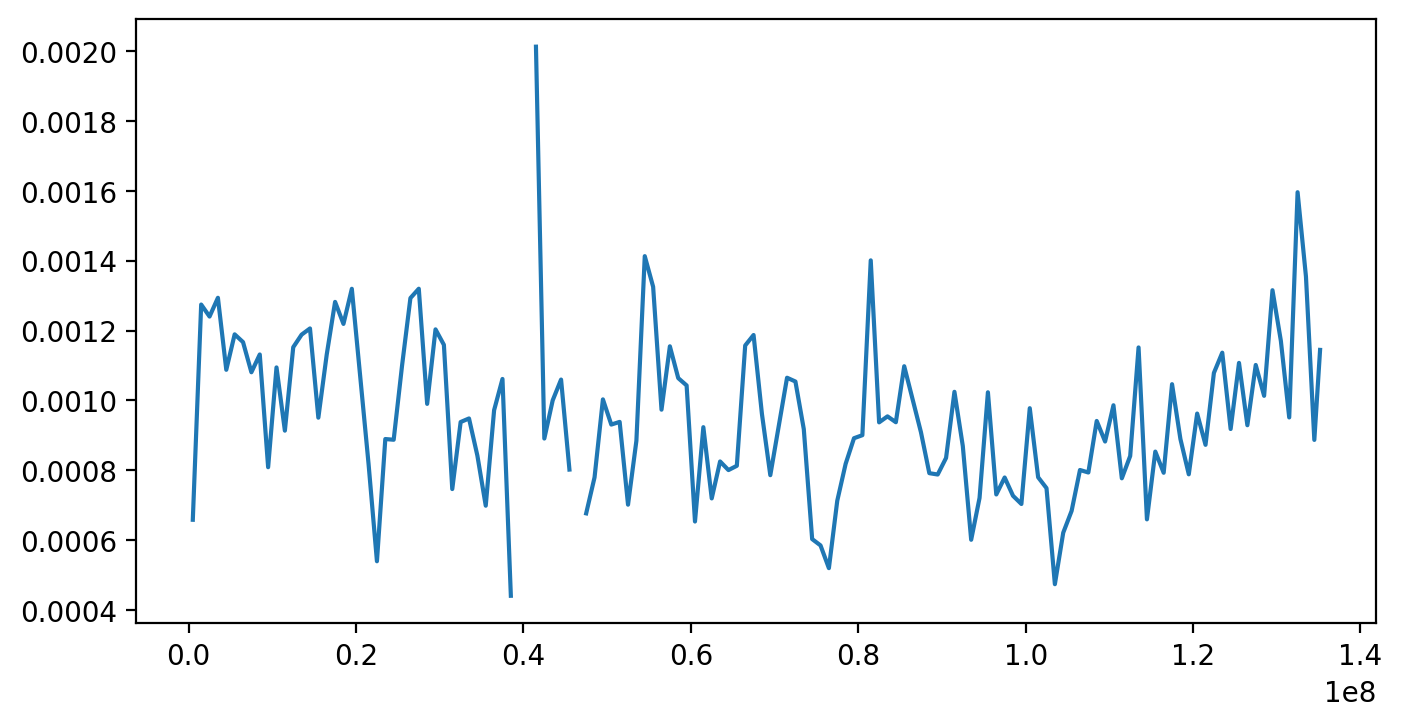

In [15]:
ddd = dalt_pi.loc[dalt_pi.chr == 'chr10']
plt.plot(ddd.midpoint, ddd.value)

(array([1.000e+02, 2.065e+03, 4.880e+02, 2.100e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00054257, 0.00108514, 0.00162772, 0.00217029,
        0.00271286, 0.00325543, 0.00379801, 0.00434058, 0.00488315,
        0.00542572]),
 <BarContainer object of 10 artists>)

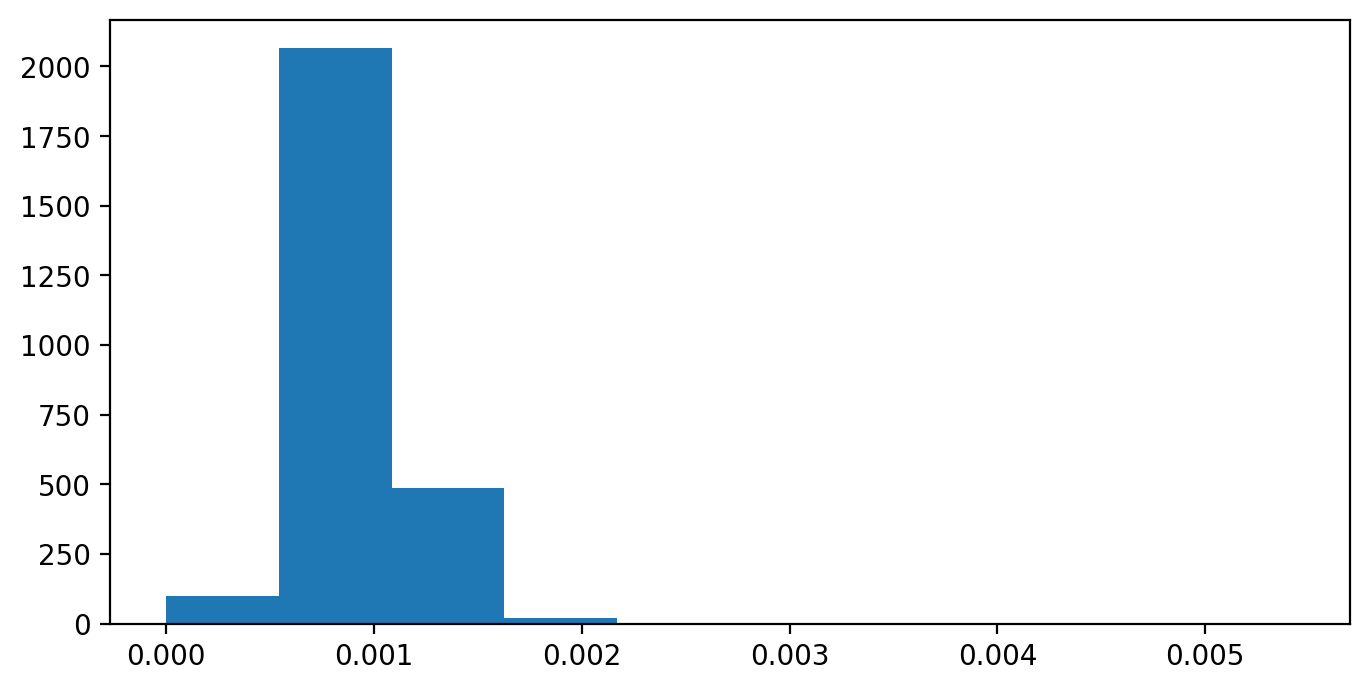

In [16]:
plt.hist(dalt_pi['value'])

This file is from a figure in Murphy et al. (2022) — I digitized this using the web digitizer tool for comparison with our values. This also uses hg18 data so there is some discrepency due to coordinate shifts.

In [17]:
md = pd.read_csv('../data/murphy_digitized.csv', names=('pos', 'pi'))

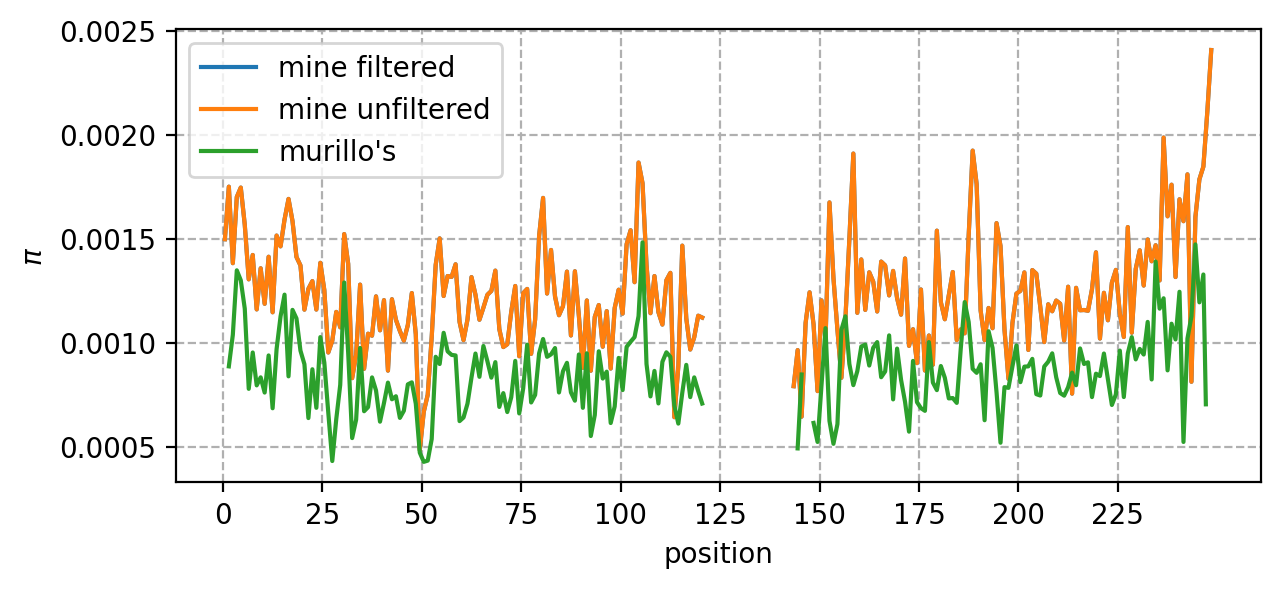

In [18]:
fig, ax = plt.subplots(figsize=(7, 3))

def to_mb(x):
    return x / 1e6

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), y, label='mine filtered')

x, y = pi_alt['chr1'].pairs
ax.plot(to_mb(x), y, label='mine unfiltered')

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), dalt_pi_chr1.value, label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

The overall patterns are quite close; Murillo's data is a bit lower as it includes bottlenecked Europeans. Let's take the $\frac{\pi}{\bar{pi}}$ ratio to put these on the same scale:

NameError: name 'ratio' is not defined

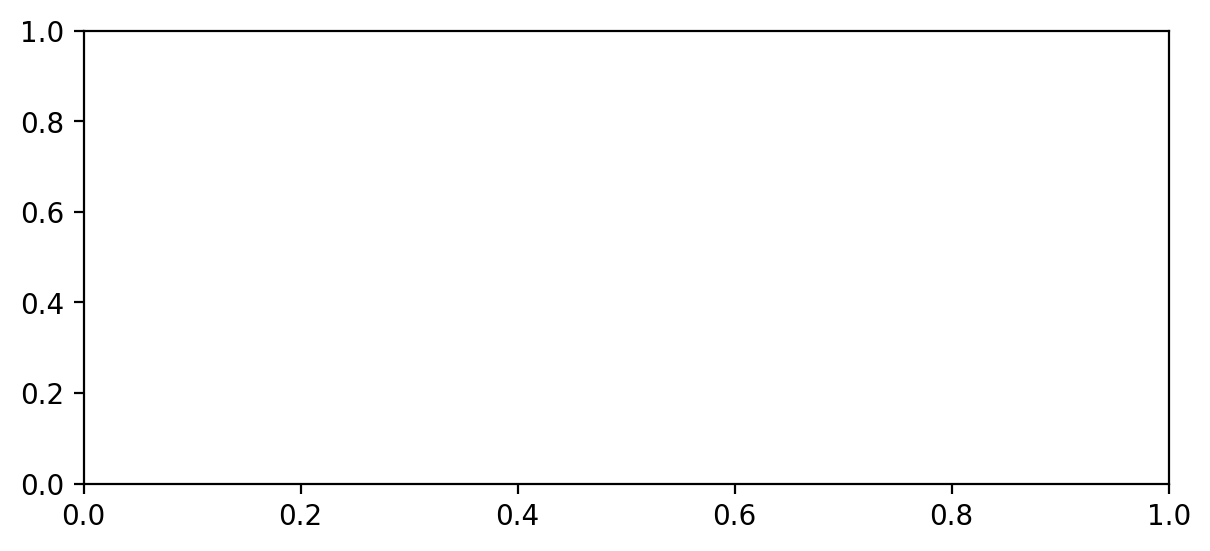

In [19]:
fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), ratio(y), label='mine filtered', zorder=3, linewidth=1)

x, y = pi_alt['chr1'].pairs

ax.plot(md['pos'], mean_ratio(md['pi']), label='murphy, digitized', linewidth=1)

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), mean_ratio(dalt_pi_chr1.value), label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi/\\bar{\pi}$')
ax.legend(ncol=2)
ax.grid(linestyle='dashed')

## Genome-Wide Diversity

Let's now look at the data binned data reduction which takes the matrix of allele counts $\mathbf{A}$ ($n_\text{sites} \times 2$ of reference/alt allele counts) and translates this to an equally-dimensioned matrix $\mathbf{Y}$ containing the number of same and different pairwise differences, $\mathbf{Y} = (\mathbf{n_S}, \mathbf{n_D})$. 

Then, pairwise diversity is 

$$\mathbf{\pi} = \frac{\mathbf{n_D}}{\mathbf{n_S} + \mathbf{n_D}}$$

where division is taken element-wise. Note that some windows have inaccessible and NaN or 0 in the data and all chromosomes are concatenated.

In [ ]:
windsize = 1e6

bins, Y = gd.bin_reduce(windsize, merge=True, filter_accessible=True, filter_neutral=True)

Now, let's look at the distribution of $\pi$ across the genome.

In [ ]:
def chromplot(midpoint_bins, Y):
    chroms = np.array([int(chrom.replace('chr', '')) for chrom, pos in midpoint_bins])
    mps = np.array([int(pos) for chrom, pos in midpoint_bins])
    x = np.cumsum(mps)
    for chrom in set(chroms):
        idx = chrom == chroms
        pi = pi_from_pairwise_summaries(Y[idx, :])
        plt.plot(x[idx], pi, label=chrom)
    plt.ylabel('$\pi$')
    plt.xlabel('position')

In [ ]:
chromplot(bins.flat_midpoints, Y)

Note that there are some extreme outliers. How do these distort the genome-wide distriubtion of $\pi$?

In [ ]:
def Y_hist(Y, nbins=100, normal=True):
    """
    Converts Y to π and plots histogram.
    """
    ndiff = Y[:, 1]
    npairs = Y.sum(axis=1)
    pi = np.divide(ndiff, npairs, out=np.full(Y.shape[0], np.nan), 
                   where=npairs > 0)
    _ = plt.hist(pi, nbins, density=True)
    loc, scale = np.nanmean(pi), np.nanstd(pi)    
    if normal:
        z = np.linspace(np.nanmin(pi)*0.99, np.nanmax(pi)*1.01, 1000)
        plt.plot(z, stats.norm(loc=loc, scale=scale).pdf(z), c='r')
    plt.title(f"$\mu={loc:0.4g}, \sigma = {scale:0.4}$")
    plt.xlabel('$\pi$')

In [ ]:
Y_hist(Y)

Let's filter these out by using a trimmed statistic.

We'll not trim the left side — only the right.

In [ ]:
binsf, Yf, idx = trimmed_bins(Y, bins=bins, alpha=(0.0, 0.999))

In [ ]:
N = Yf.sum(axis=1).mean()

# what are the summary stats after filtering?
pim = pi_from_pairwise_summaries(Yf).mean()
pisd = pi_from_pairwise_summaries(Yf).std()

In [ ]:
pim, pisd

In [ ]:
Y_hist(Yf, nbins=50)
#z = np.linspace(5e-4, 0.00250, 50)
#plt.plot(z, stats.norm(loc=pim, scale=np.sqrt(pim*(1-pim)/15000)).pdf(z))

How close is this to a normal?

In [24]:
pi = pi_from_pairwise_summaries(Yf)
z = np.linspace(pi.min(), pi.max(), 100)
loc, scale = stats.norm.fit(pi)
stats.kstest(pi, stats.norm(loc, scale).cdf)

KstestResult(statistic=0.04371953157613173, pvalue=7.863002370395687e-05)

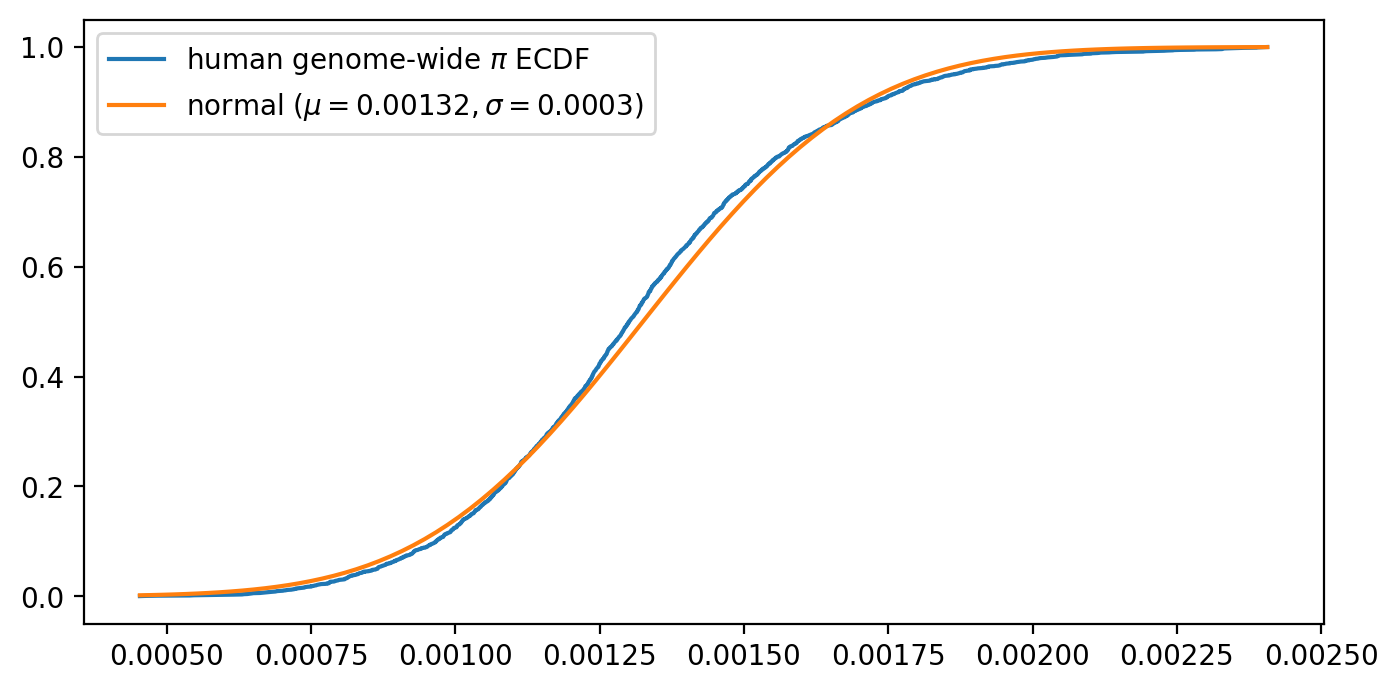

In [25]:
plt.plot(np.sort(pi), (1+np.arange(len(pi)))/len(pi), label='human genome-wide $\pi$ ECDF')
plt.plot(z, stats.norm(*stats.norm.fit(pi)).cdf(z), label=f'normal ($\mu={loc:.3g}, \sigma={scale:.3g}$)')
plt.legend()

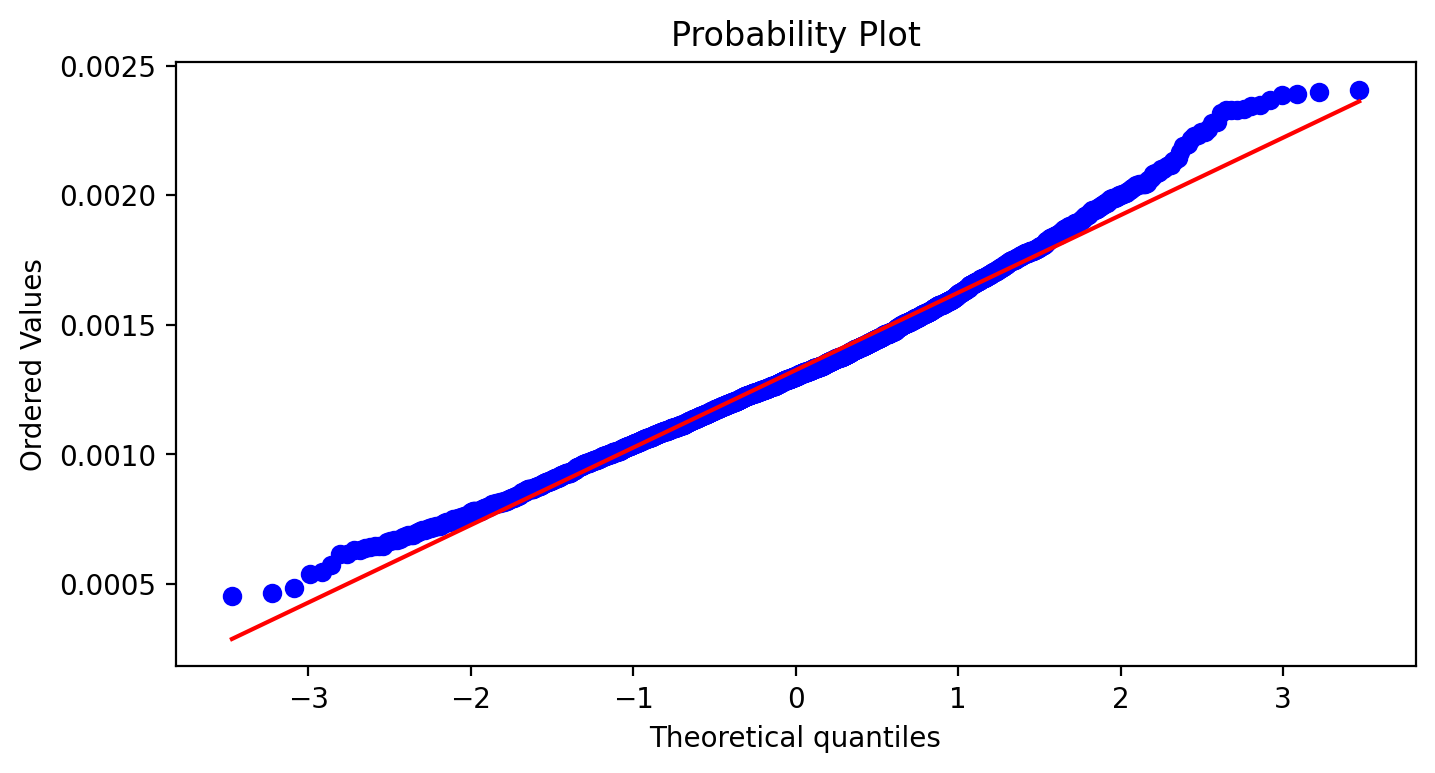

In [26]:
_ = stats.probplot(pi, dist="norm", plot=plt)

Things look a tad distorted. The left tail is a bit thin and the right tail is a bit fat (even after filtering).

In [27]:
# skew and excess kurtosis (Pearson's kurtosis - 3)
stats.skew(pi), stats.kurtosis(pi) - 3

(0.4370890111861593, -2.5854689653735523)

This confirms: excess kurtosis is negative, things are platykurtotic (thin tails). The skew is positive.

Let's look now at the post-trimmed distribution across the genome:

In [28]:
binsf_midpoints = [(c, (start+end)/2) for c, start, end in binsf]

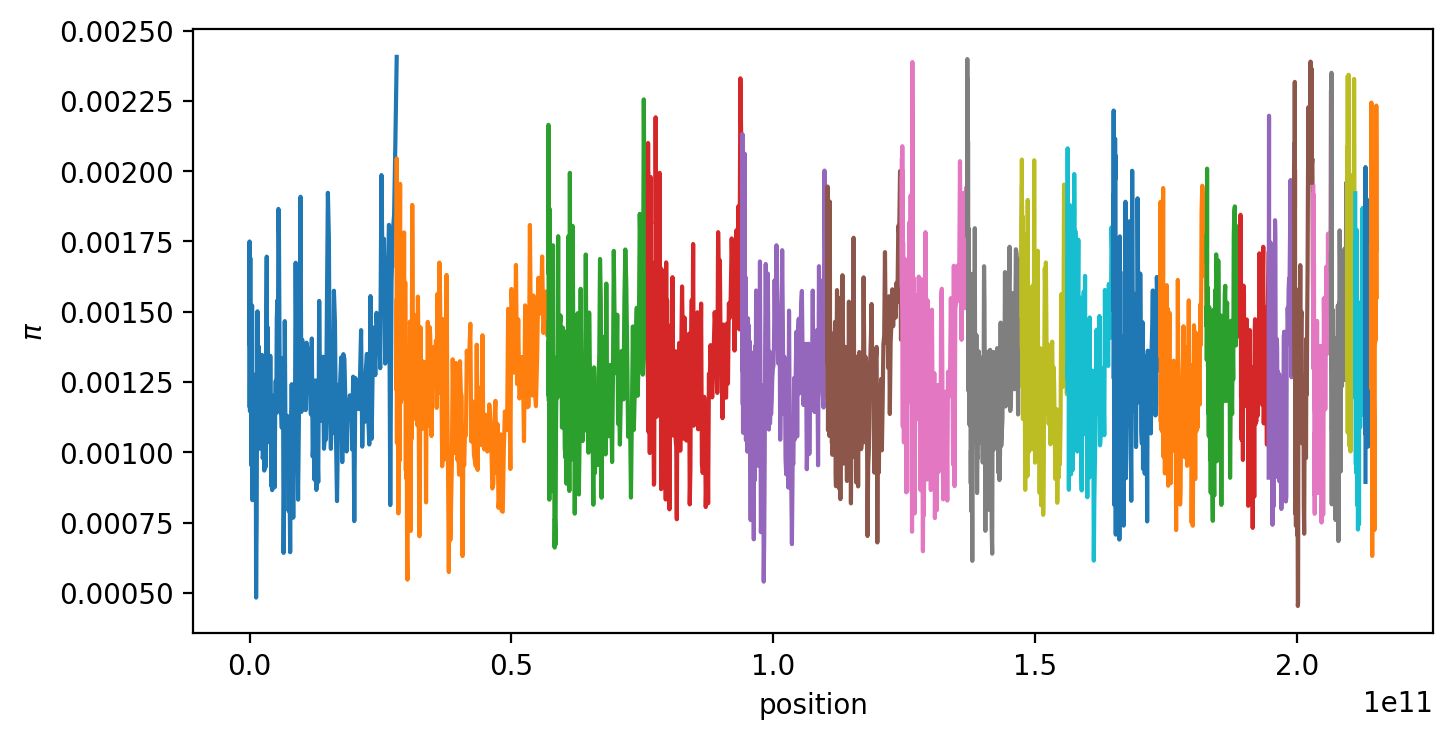

In [29]:
chromplot(binsf_midpoints, Yf)

## Dependencies

Bins are spatially correlated, creating dependencies in the data. We assess and model these here.

Since we reduce data at the megabase bin level, we want to look at the level of autocorrelation/autocovariance at differing levels of bins away using a covariogram. One quick way to do this is

$$g(l) = \mathrm{cov}(i, i+l)$$

where $l$ is the bin index lag. Since recombination rates vary, we also look put this on the natural scale of map position.
 
$$g_m(m) = \mathrm{E}(\mathrm{cov}(i, i+l) | m)$$

TODO: fix above

### Model

We can think about our model as,

$$
\pi(z) = \underbrace{\pi_0 B(z | \theta)}_\text{mean field} + \epsilon(z)
$$

Our error term $\epsilon(z)$ is possible spatially autocorrelated. There exists some empirical covariogram function $\hat{C}(h) = \mathrm{cov}(Y(z), Y(z+h))$ we can estimate from the data directly. However, we are uncertain about both (1) the spatial scale of $\hat{C}(h)$ and (2) whether the dependency is caused by autocorrelation in the mean field $B(z)$ or the error term $\epsilon(z)$. Here, $\epsilon(z)$ includes sampling processes and random genetic drift around the mean field.

We can determine (1) directly from the empirical data. For (2), it is trickier — the clearest way is to generate Monte Carlo realizations of $\pi(z)$ under the neutral process and the sampling process and measure the spatial scale of $C(h)$ (we do this at the very end).


Since mutation is a Poisson point process along the chromosome, we must define the scale at which we measure it.

The bigger question is whether we model the covariance structure, regardless of its source, when trying to estimate $\theta$ from $\pi(z)$. Fundamentally, a composite likelihood assumes independence between binned measurements of $\pi(z)$ — in the case of learning $\theta)$, we want to *discount* nearby observations by some amount because they're not telling us independent bits of information about $\theta$, but rather looking at the same section of $B(z | \theta)$. Thus, we want to control for the total autocovariance. Note that this parallels some debate about what we are controlling for in phylogenetic comparative methods, as well as causal literature. However in this latter case, note that we're not really "controlling" for things in the same way, as we're modeling covariance, not fixed or random effects.

Another way to think about this is: if we generate a random process under $B(z | \theta)$, do we get better inferences if we control for covariance between observations?

One thing is that the mean field itself is *random*, and in this sense, it does make sense to downweight neighboring observations.

In [35]:
# the interface to non-chromosome spanning (e.g. filtered) bins is a bit clunky, hence these:

def midpointbins_to_mapbins(bins, genome):    
    g = genome
    mbins = [(c, float(g.recmap.lookup(c, p, cummulative=True))) for c, p in bins.flat_midpoints]
    chroms, pos = list(zip(*mbins))
    return np.array(chroms), np.array(pos)

def bins_to_mapbins(bins, genome):
    g = genome
    mbins = [(c, float(g.recmap.lookup(c, (s+e)/2, cummulative=True))) for c, s, e in bins]
    chroms, pos = list(zip(*mbins))
    return np.array(chroms), np.array(pos)
    

Whole genome π covariance (note this is an approximation since lags across chromosomes are included).

In [36]:
pi_chroms = np.array([c for c, _, _ in binsf])

Text(0.5, 1.0, 'cov(i, i-1) = 3.308e-08, var(i-1, i-1) = 6.887e-08, var(i, i) = 6.887e-08')

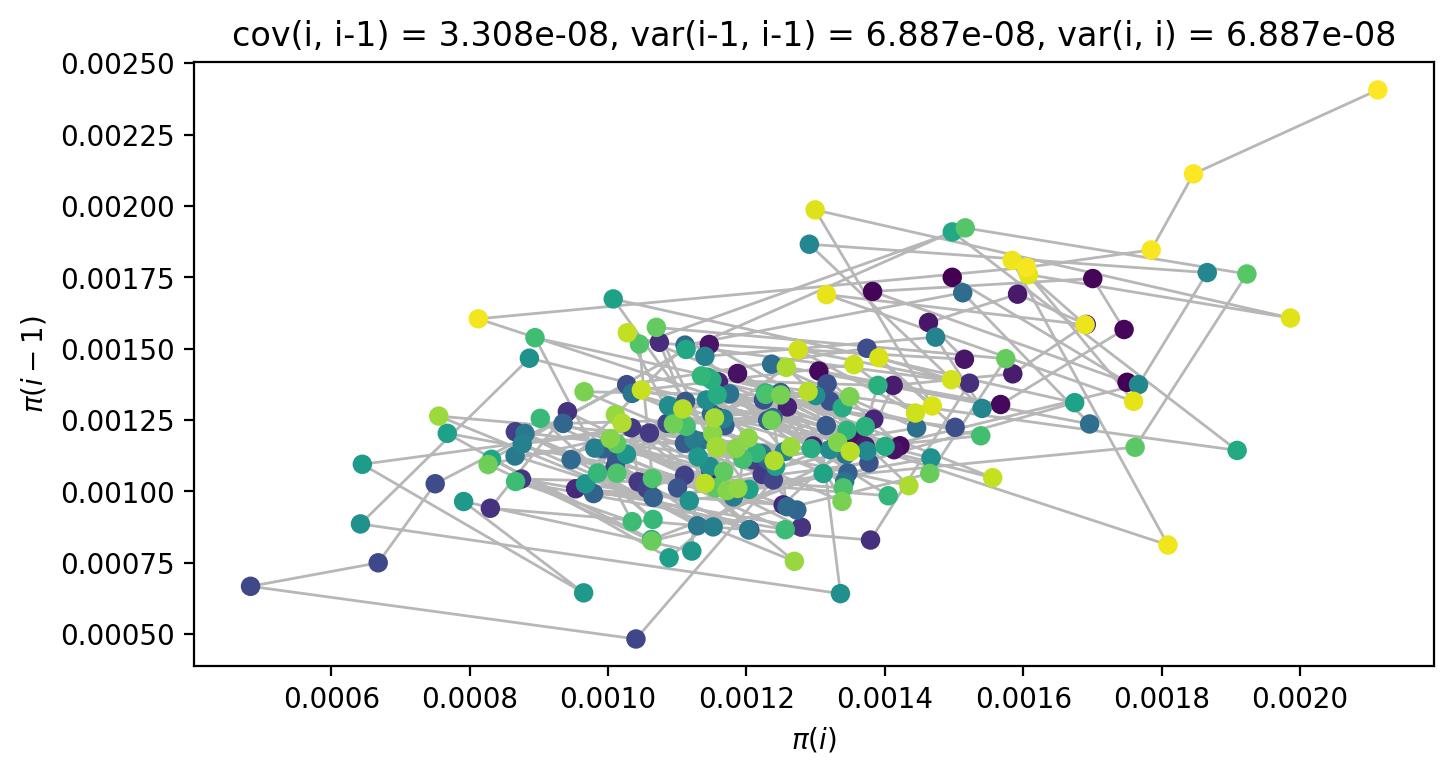

In [37]:
idx2 = pi_chroms == 'chr1'
lag = 1
xpi = pi[idx2]
p1, p2 = xpi[:-(lag)], xpi[(lag):]

plt.plot(p1, p2, linewidth=1, c='0.44', alpha=0.5)
plt.scatter(p1, p2, c=np.arange(len(xpi[(lag):])), zorder=3)
plt.xlabel('$\pi(i)$')
plt.ylabel('$\pi(i-1)$')
#plt.scatter(pi[:-1], pi[1:], c=pi[1:], zorder=3)
cov = np.cov(p1, p2)
plt.title(f"cov(i, i-1) = {cov[0, 1]:.4}, var(i-1, i-1) = {cov[0, 0]:.4}, var(i, i) = {cov[0, 0]:.4}")

Is this first-order covariance significant? Let's do a permutation test:

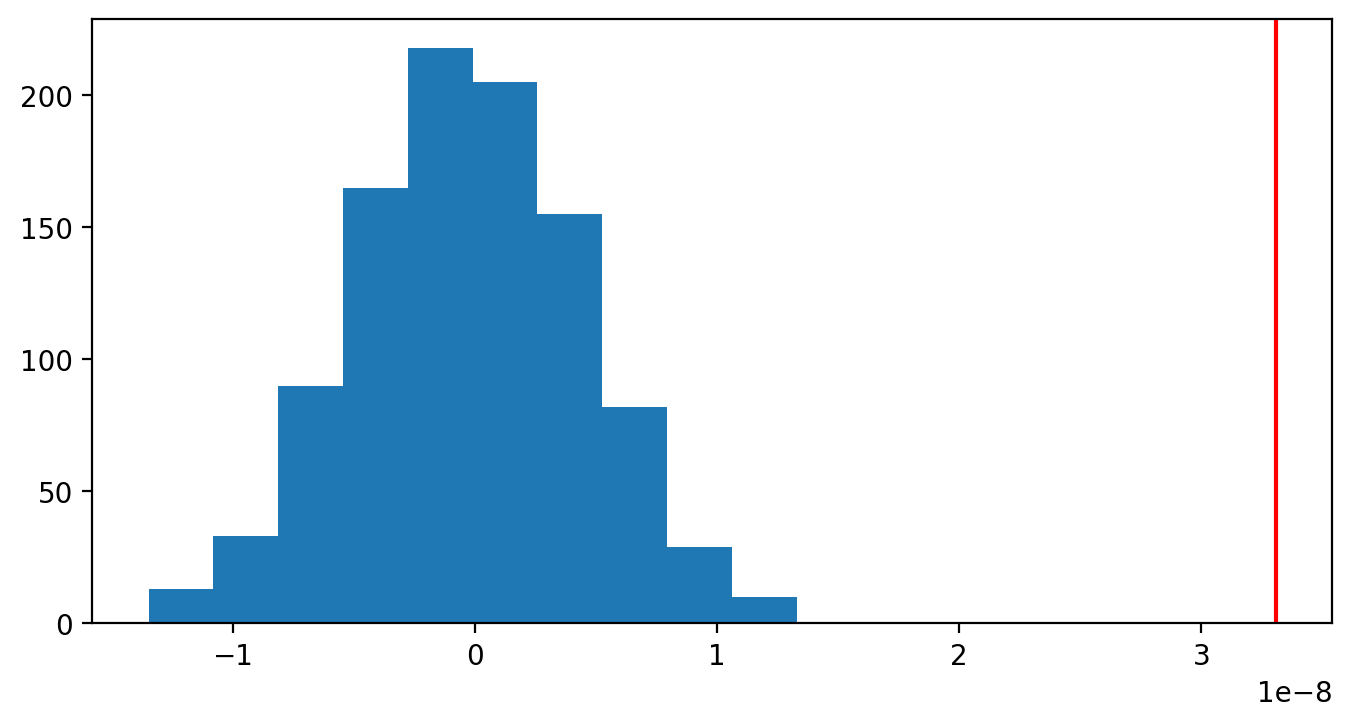

In [38]:
nperms = 1000
null = np.zeros(nperms)
for i in range(nperms):
    null[i] = np.cov(p1, np.random.permutation(p2))[0, 1]

plt.hist(null)
plt.axvline(np.cov(p1, p2)[0, 1], c='r')

## Binned Variograms

In [112]:
def binned_funcgram(y, chroms, positions, func=lambda x, y: np.mean((x-y)**2), max_lag=50):
    all_lags = list(range(1, max_lag))
    
    stats = []
    lags = []
    ns = []

    all_chroms = list(set(chroms))
    
    # things are done at the per-chrom level so that we don't get lag runover
    for chrom in all_chroms:
        idx = chroms == chrom
        y_chrom = y[idx]
        x_chrom = positions[idx]

        chrom_stats = []
        chrom_lag = []
        chrom_ns = []
        for lag in all_lags:
            if lag >= x_chrom.size-1:
                chrom_stats.append(np.nan)
                chrom_lag.append(np.nan)
                chrom_ns.append(np.nan)
                continue
            # first, we average/bin the distance for this shifted window lag
            d = np.abs(x_chrom[:-lag] - x_chrom[lag:]).mean()
            assert not np.isnan(d)
            y1, y2 = y_chrom[:-lag], y_chrom[lag:]
            keep = ~np.isnan(y1) & ~np.isnan(y2)
            if lag >= x_chrom.size-1 or keep.sum() < 2:
                chrom_stats.append(np.nan)
                chrom_lag.append(np.nan)
                chrom_ns.append(np.nan)
                continue
            y1, y2 = y1[keep], y2[keep]
            stat = func(y1, y2)
            chrom_stats.append(stat)
            chrom_ns.append((keep).sum())
            chrom_lag.append(d)
        stats.append(chrom_stats)
        lags.append(chrom_lag)
        ns.append(chrom_ns)
    return all_chroms, np.array(lags).T, np.array(stats).T, np.array(chrom_ns).T

In [113]:
# convert physical bin positions to map positions
chroms, map_positions = midpointbins_to_mapbins(bins, g)

Text(0.5, 0, 'lag (Morgans)')

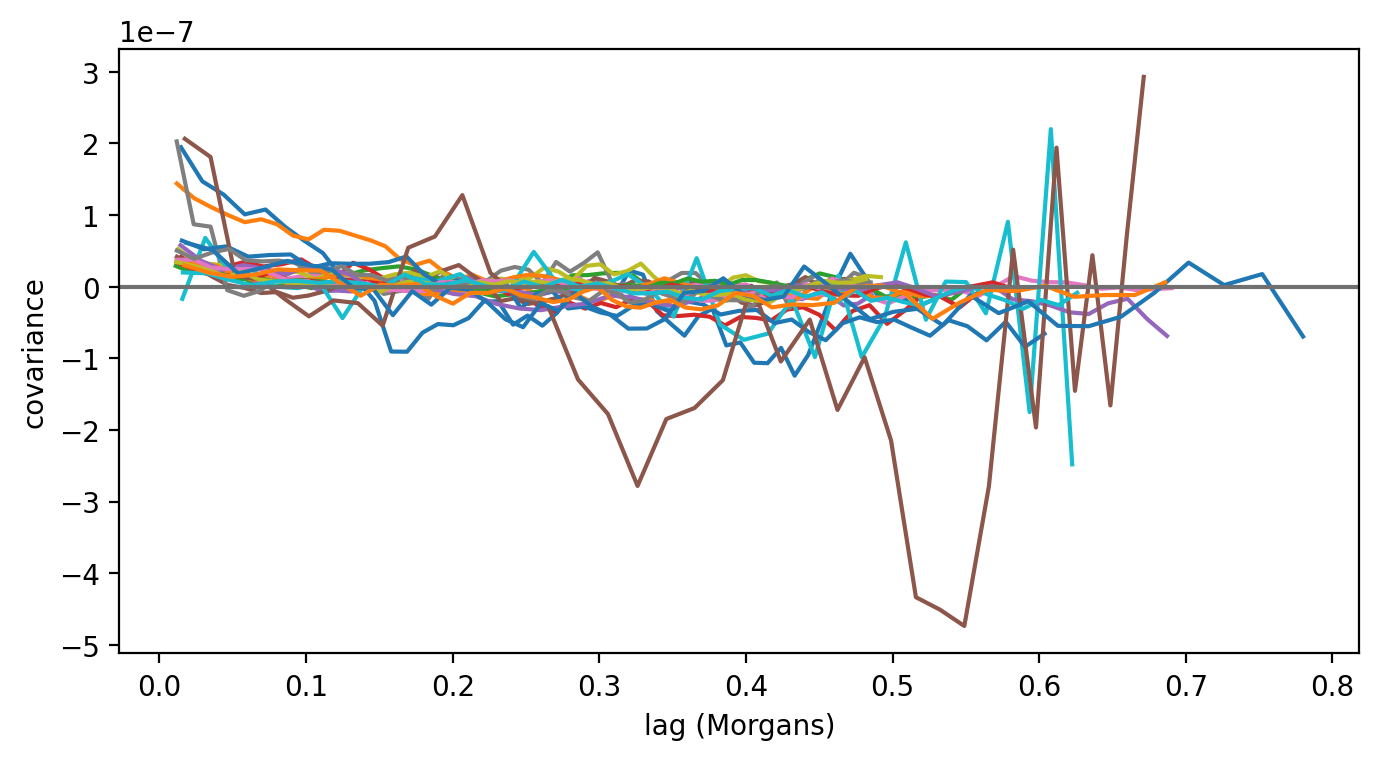

In [114]:
pi = pi_from_pairwise_summaries(Y)
cov_chroms, cov_lags, cov_stats, cov_ns = binned_funcgram(pi, chroms, map_positions, func=lambda x, y: np.cov(x, y)[0, 1])
_ = plt.plot(cov_lags, cov_stats, label=cov_chroms)
plt.axhline(0, c='0.44')
plt.ylabel("covariance")
plt.xlabel("lag (Morgans)")

In [115]:
cov_ns

array([57, 55, 53, 51, 49, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36,
       35, 34, 33, 32, 31, 30, 29, 28, 28, 28, 28, 28, 28, 28, 27, 26, 25,
       25, 25, 25, 25, 25, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16])

Text(0.5, 0, 'lag (Morgans)')

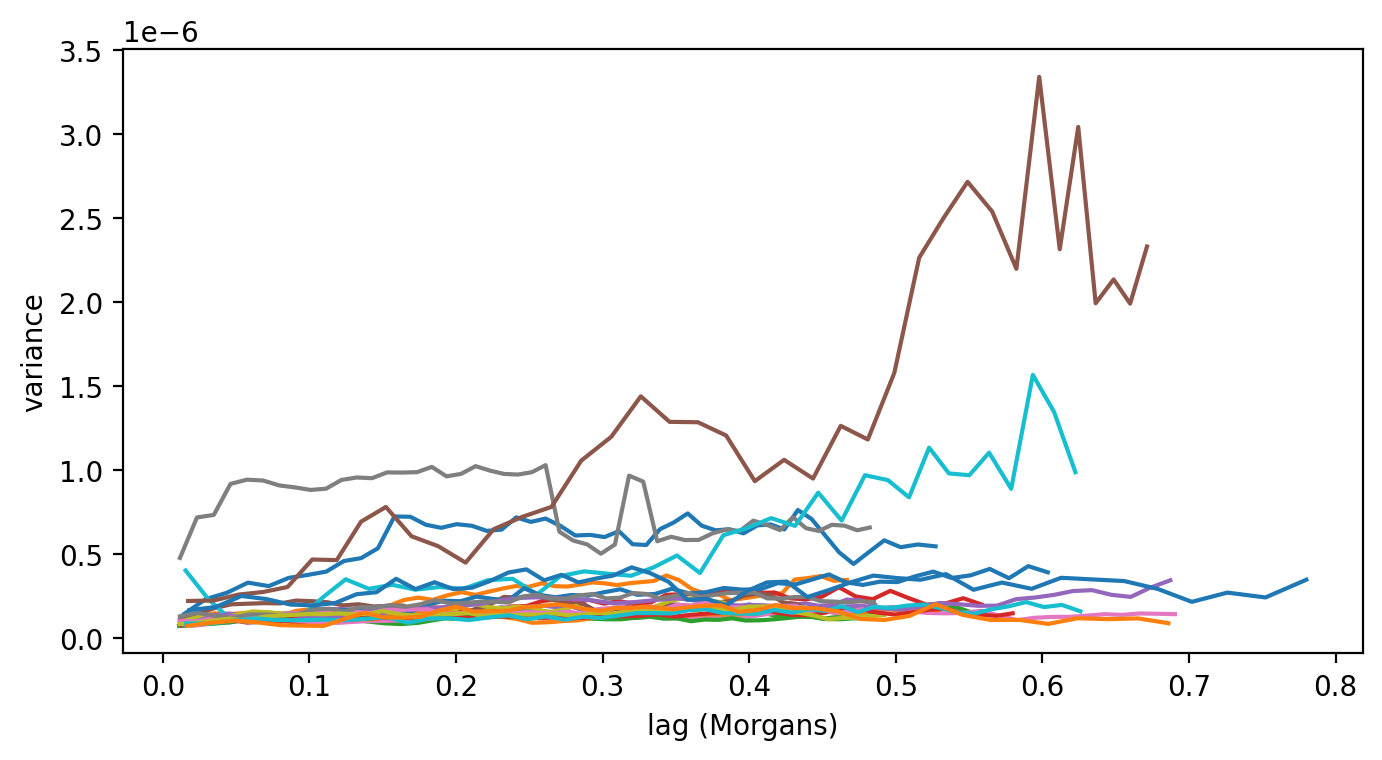

In [46]:
var_chroms, var_lags, var_stats = binned_funcgram(pi, chroms, map_positions, func=lambda x, y: np.mean((x-y)**2))
_ = plt.plot(var_lags, var_stats, label=var_chroms)
plt.ylabel("variance")
plt.xlabel("lag (Morgans)")

Now let's look at the filtered data.

In [48]:
chroms_filt, map_positions_filt = bins_to_mapbins(binsf, g)

Text(0.5, 0, 'lag (Morgans)')

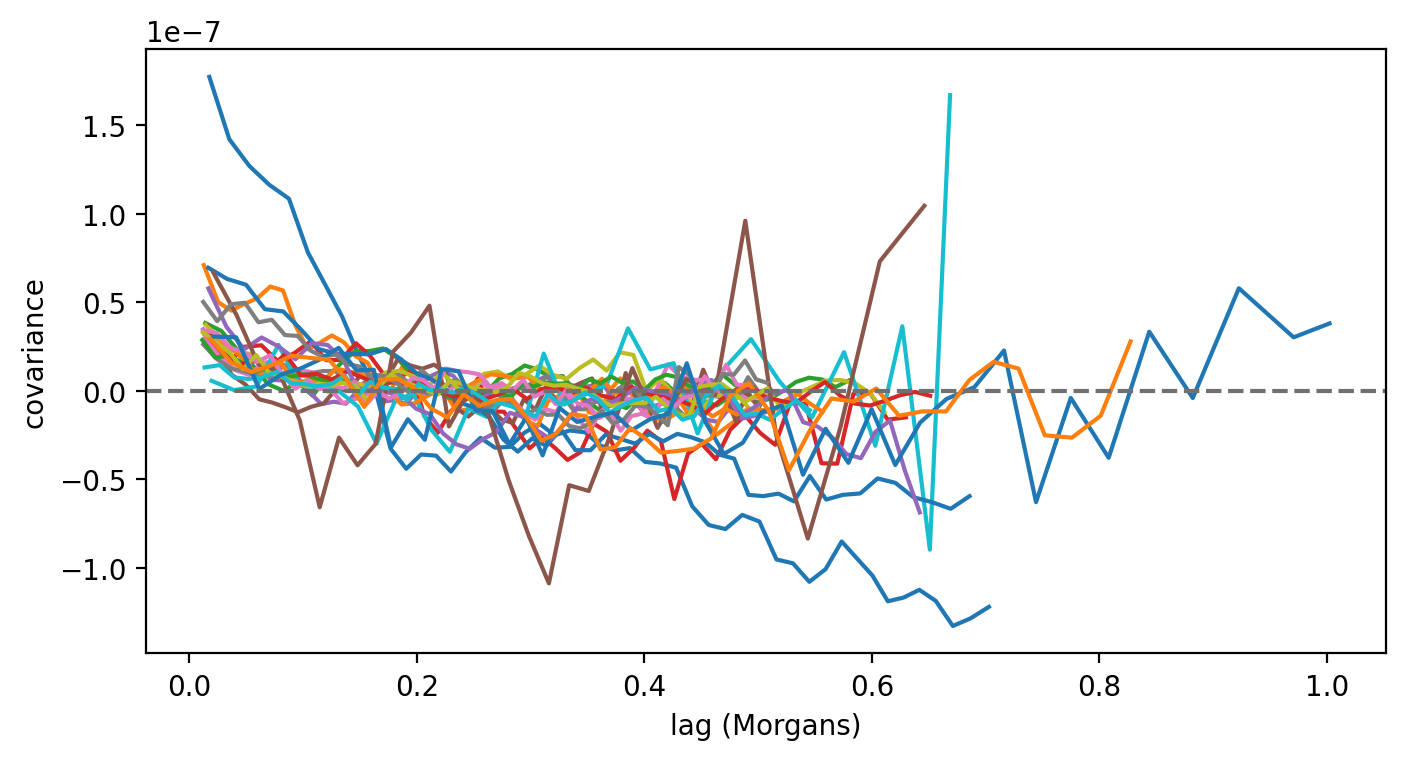

In [56]:
pi_filt = pi_from_pairwise_summaries(Yf)
cov_chroms, cov_lags, cov_stats = binned_funcgram(pi_filt, chroms_filt, map_positions_filt, func=lambda x, y: np.cov(x, y)[0, 1])
_ = plt.plot(cov_lags, cov_stats, label=cov_chroms)
plt.axhline(0, linestyle='dashed', c='0.44')
plt.ylabel("covariance")
plt.xlabel("lag (Morgans)")

Text(0.5, 0, 'lag (Morgans)')

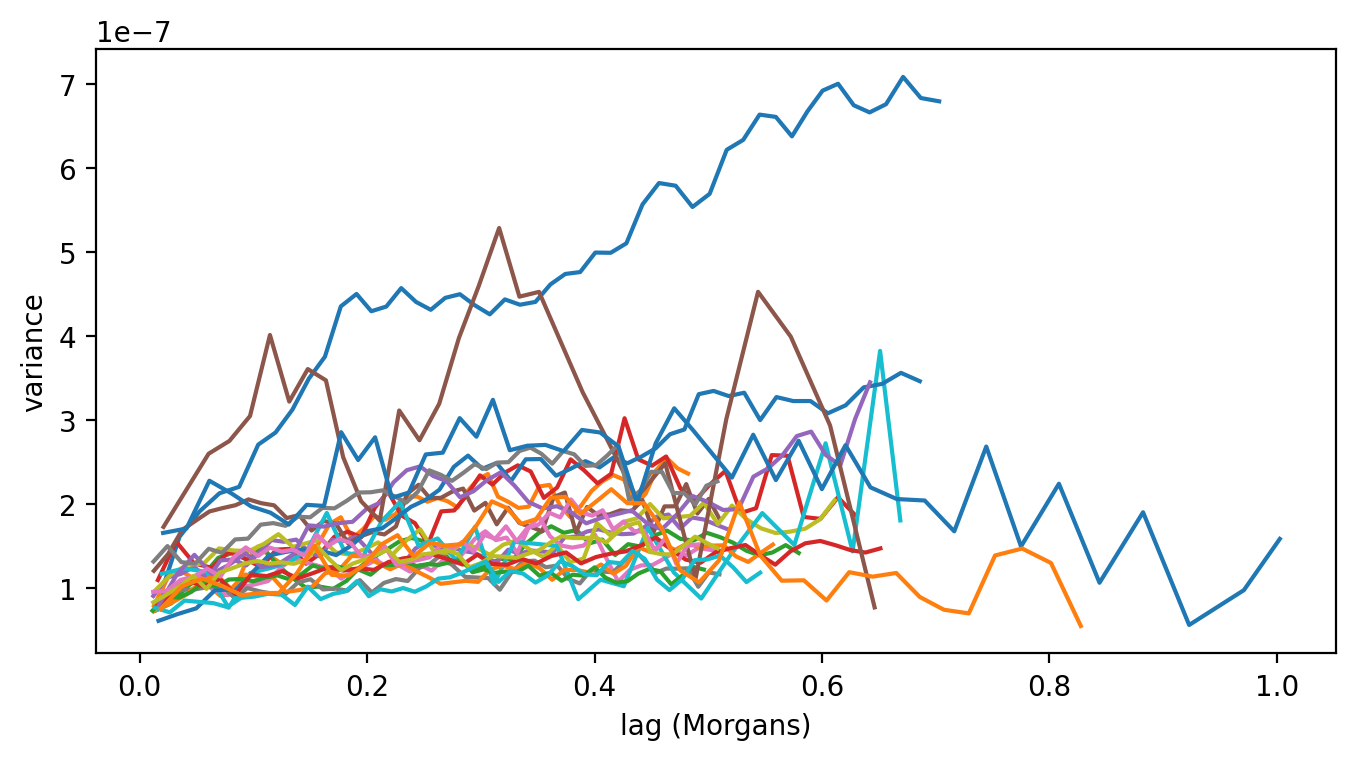

In [50]:
var_chroms, var_lags, var_stats = binned_funcgram(pi_filt, chroms_filt, map_positions_filt, func=lambda x, y: np.mean((x-y)**2))
_ = plt.plot(var_lags, var_stats, label=var_chroms)
plt.ylabel("variance")
plt.xlabel("lag (Morgans)")

Now let's bootstrap the diversity covariogram at the chromosome level:

Text(0, 0.5, 'covariance')

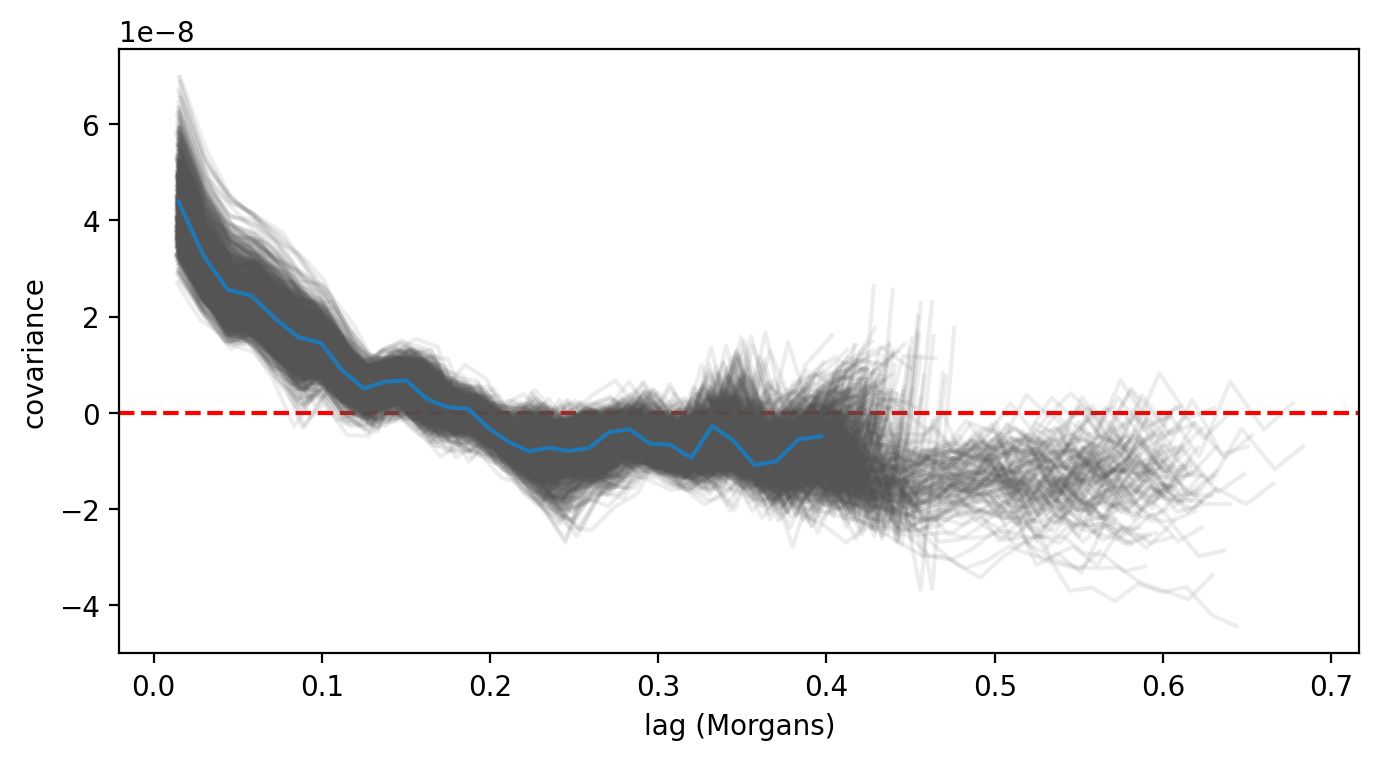

In [127]:
# with pi
cov_chroms, cov_lags, cov_stats, cov_ns = binned_funcgram(pi_filt, chroms_filt, map_positions_filt, func=lambda x, y: np.cov(x, y)[0, 1])

M = cov_stats.T
P = cov_lags.T
bs = []
ms = []
stat = np.mean
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

Note that it looks like there's some bias here. It's unclear the cause — but we can imagine that some sampling noise could impose a bias. For example, $\mathrm{cov}(\pi(i) + e(i), \pi(i +h) + e(i + h)) = \mathrm{cov}(\pi(i), \pi(i+h)) + \mathrm{cov}(e(i), e(i + h))$ assuming error and $\pi$ are orthogonal. This opens the possibility of bias due to sampling noise, in the case where sampling noise is negatively autocorrelated across windows.

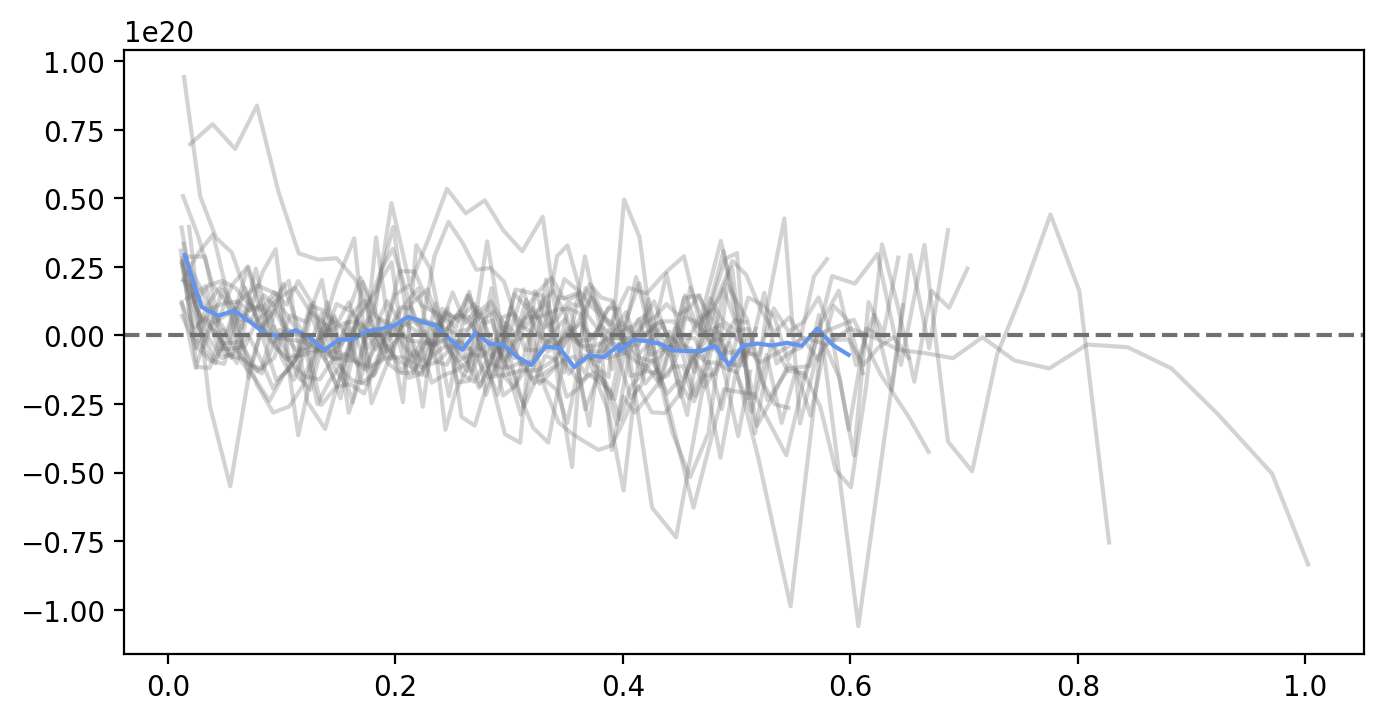

In [129]:
# what's the correlation in comparisons per window?
z = Yf.sum(axis=1)
lag = 10
covs = []
_, x, y, _ = binned_funcgram(z, chroms_filt, map_positions_filt, func=lambda x, y: np.cov(x, y)[0, 1])
_ = plt.plot(x, y, c='0.44', alpha=0.3)
plt.plot(np.nanmean(x, axis=1), np.nanmean(y, axis=1), c='cornflowerblue')
plt.axhline(0, c='0.44', linestyle='dashed')

Text(0, 0.5, 'covariance')

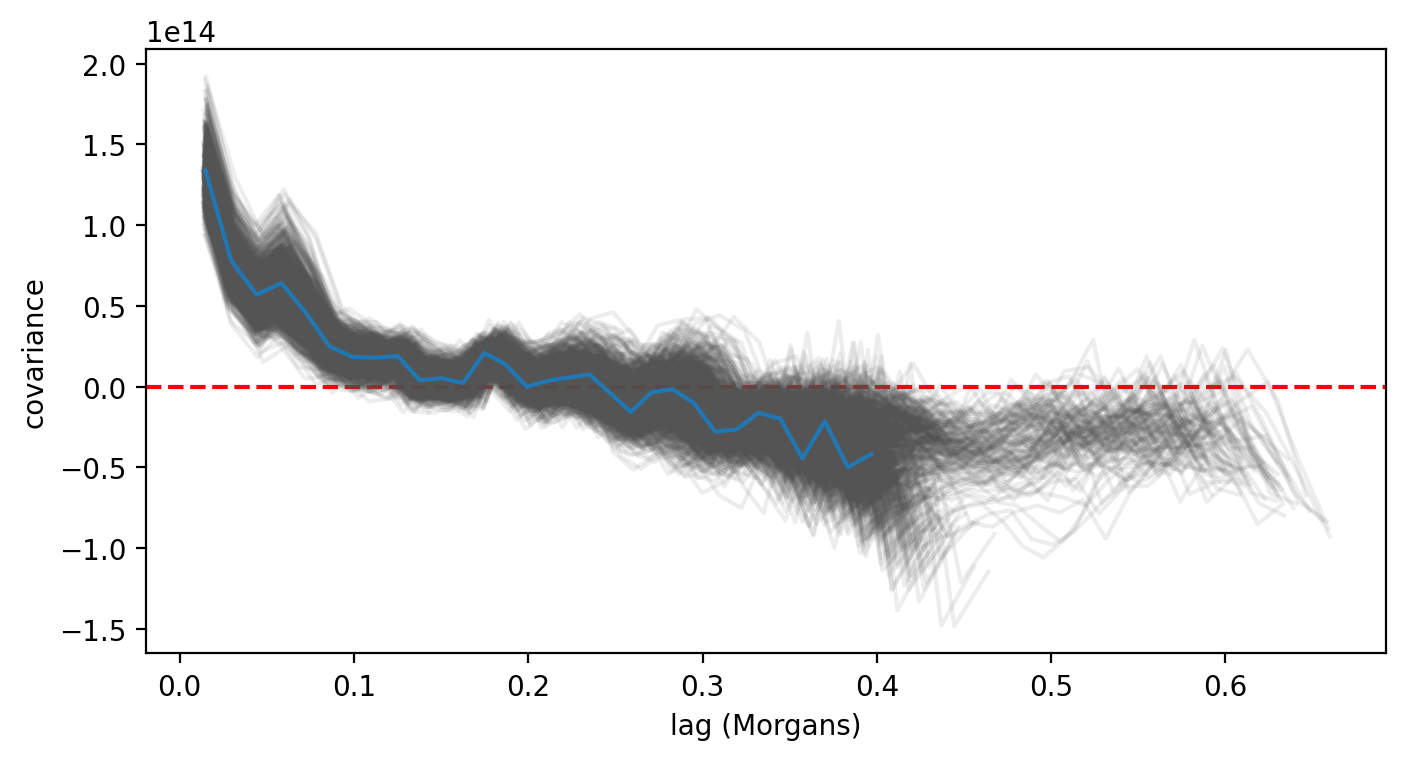

In [130]:
# Note: we have to model the kernel at the counts level (π(x) N(x)) since
# this is going to the normal approximation model
cov_chroms, cov_lags, cov_stats, cov_ns = binned_funcgram(Yf[:, 1], chroms_filt, map_positions_filt, 
                                                          func=lambda x, y: np.cov(x, y)[0, 1])

M = cov_stats.T
P = cov_lags.T
bs = []
ms = []
stat = np.mean
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

## Parametric Fitting of the Kernel

Let us fit a simple decay kernel

In [119]:
@np.vectorize
def squared_exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d**2/rho) + bias

@np.vectorize
def exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d/rho) + bias

In [121]:
x, y = np.mean(P, axis=0), np.mean(M, axis=0)
x, y = x[~np.isnan(x)], y[~np.isnan(y)]

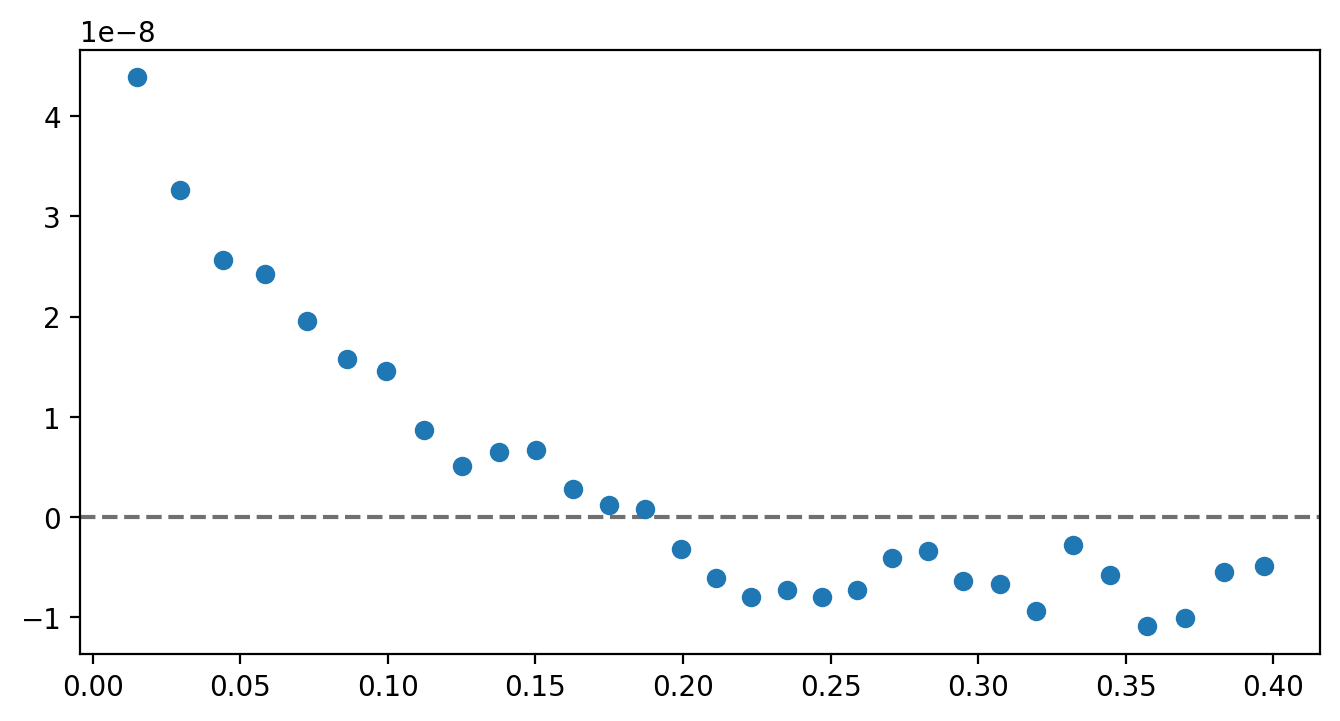

In [123]:
plt.scatter(x, y)
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
#plt.plot(x, exponential(x, 1e7, 0.1, -0.4e14), linestyle='dashed')


In [ ]:
def mse_kernel(x, y):
    def func(theta):
        alpha, rho, bias = theta
        #alpha, rho = 10*alpha, 10**rho
        yp = exponential(x, alpha, rho, bias)
        return np.mean((yp - y)**2) / np.var(y)
    return func
    
opt = minimize(mse_kernel(x, y), 
               x0=[1e7, 0.1, -0.4e14], 
               bounds=[(0, np.Inf), (0, np.Inf), (-np.Inf, np.Inf)], 
               #options={'ftol':1e-3, 'eps':1e-5},
               method='Nelder-Mead')
opt

Compare to scipy's `curve_fit()`:

In [ ]:
params, param_covs = curve_fit(exponential, x, y, p0=[1e7, 0.1, -0.4e14])
params

In [ ]:
lines = plt.plot(x, exponential(x, *params) - params[2], label='bias corrected')
plt.scatter(x, y - params[2], c=lines[0].get_color())
lines = plt.plot(x, exponential(x, *params), label='uncorrected')
plt.scatter(x, y, c=lines[0].get_color())
plt.plot(x, exponential(x, *opt.x), linestyle='dashed')
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')
plt.legend()

In [ ]:
z = np.linspace(0, 1, 1000)
lines = plt.plot(z, exponential(z, *params) - params[2])
plt.scatter(x, y - params[2], c=lines[0].get_color())
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')

In [ ]:
len(map_binsf)

In [ ]:
def predict_chromosome_covariances(mapbins, Y, kernel, bias=None):
    assert Y.shape[0] == len(mapbins), "len(mapbins) ≠ Y.shape[0]"
    chroms = np.array([c for c, _ in mapbins])
    all_chroms = list(set(chroms))
    Sigma = dict()
    for chrom in all_chroms:
        idx = chroms == chrom
        pi = pi_from_pairwise_summaries(Y[idx, :])
        N = Y[idx, :].sum(axis=1)
        Var = pi*(1-pi)*N
        pos = np.array([p for keep, (_, p) in zip(idx.tolist(), mapbins) if keep])
        assert pos.size == idx.sum()
        
        # compute the map distance matris for the kernel cov prediction
        pos_x, pos_y = np.meshgrid(pos, pos)    
        dist = np.abs(pos_x - pos_y)
        bias = bias if bias is not None else 0
        Cov = kernel(dist) - bias
        
        # fill in the diagonal with the proper variances
        #np.fill_diagonal(Cov, Var)    
        Sigma[chrom] = Cov
    return Sigma

fit_kernel = partial(exponential, alpha=params[0], rho=params[1], bias=params[2])

cms = predict_chromosome_covariances(map_binsf, Yf, fit_kernel)

In [ ]:
def is_posdef(X):
    return np.all(np.linalg.eigvals(X) > 0)


is_posdef(cms['chr1'])

In [ ]:
Sigma.max()

In [ ]:
# without fixing bias (note color scale < 0):

Sigma = cms['chr1']

cmap = mpl.cm.get_cmap('Spectral_r')
norm = mpl.colors.TwoSlopeNorm(vmin=Sigma.min(), vcenter=0, vmax=Sigma.max())
cm = plt.imshow(Sigma, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

In [ ]:
Sigma

In [ ]:
# with fixing bias:

cms = predict_chromosome_covariances(map_binsf, Yf, fit_kernel, bias=params[2])

Sigma = cms['chr1']
Sigma_nobias = Sigma

cmap = mpl.cm.get_cmap('viridis_r')
norm = mpl.colors.Normalize(vmin=0, vmax=Sigma_nobias.max())
cm = plt.imshow(Sigma_nobias, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

In [ ]:
# how much to offdiagonals contribute to the total? note this ignores the variance, e.g. Σ + σ^2 I 
(Sigma_nobias.sum() - np.diag(Sigma_nobias).sum()) / Sigma_nobias.sum()

What's the scale of the normal approximation variance?

In [ ]:
Nf = Yf.sum(axis = 1)
pif = pi_from_pairwise_summaries(Yf) 
_ = plt.hist(Nf * (1-pif)*pif, 50)

## Simulated Kernels

In [ ]:
import tskit as ts
from bgspy.utils import bin_chrom

In [ ]:
yri_1k = ts.load('../data/sim_kernels/3G09_chr1.ts')

In [ ]:
def sim_covariogram(ts, width, nlags=50, recmap=None):
    bins = bin_chrom(ts.sequence_length, int(width))
    pi = ts.diversity(windows=bins)/4 # since μ=1
    lags = list(range(1, 50))
    covs = []
    for lag in lags:
        covs.append(np.cov(pi[lag:], pi[:-lag])[0, 1])
    if recmap is not None:
        
    plt.scatter(lags, covs, label=f'width = {width}')
    return np.array(lags), np.array(covs)

## Genomic Covariogram and Variogram Estimators

In [ ]:
def covariogram(x, chroms, pos, max_lag=50):
    lags = list(range(1, max_lag))
    covs = []
    
    for lag in lags:
        covs.append(np.cov(pi[lag:], pi[:-lag])[0, 1])
    

In [ ]:
sim_gm_file = '/home/vsb/.cache/stdpopsim/genetic_maps/HomSap/HapMapII_GRCh37/genetic_map_GRCh37_chr1.txt'

from bgspy.recmap import RecMap

sim_gm = RecMap(sim_gm_file, {'chr1': yri_1k.sequence_length})

In [ ]:
sim_covariogram(yri_1k, 1_000)
sim_covariogram(yri_1k, 10_000)
sim_covariogram(yri_1k, 100_000)
sim_covariogram(yri_1k, 1_000_000)
plt.legend()

### Should We Control For Covariance?

In [ ]:
from scipy.linalg import toeplitz

In [ ]:
TK

In [ ]:
n = 100
z = np.arange(n)
MU = np.sin(z/5) 
#MU = z
TK = exponential(toeplitz(range(n)), 1, 5) + 0.1*np.eye(n) 


In [ ]:
plt.plot(MU)
plt.plot(np.random.multivariate_normal(MU, TK))
#plt.plot(np.random.multivariate_normal(MU, np.eye(n)))

In [ ]:
plt.plot((np.random.multivariate_normal(MU, TK) - MU))

In [ ]:
plt.plot(TK[0,:])